# Regression of Used Car Prices

In [91]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import category_encoders as ce
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor

from catboost import CatBoostRegressor
from catboost import Pool

import shap


In [92]:
data = pd.read_csv('train.csv')
data.head()


id          brand              model  model_year  milage      fuel_type  \
0   0           MINI      Cooper S Base        2007  213000       Gasoline   
1   1        Lincoln              LS V8        2002  143250       Gasoline   
2   2      Chevrolet  Silverado 2500 LT        2002  136731  E85 Flex Fuel   
3   3        Genesis   G90 5.0 Ultimate        2017   19500       Gasoline   
4   4  Mercedes-Benz        Metris Base        2021    7388       Gasoline   

                                              engine  \
0       172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel   
1       252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel   
2  320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...   
3       420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel   
4       208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   

                     transmission ext_col int_col  \
0                             A/T  Yellow    Gray   
1                             A/T  Silver   Beige   
2                             A/T    Blue    Gray   
3  Transmission w/Dual Shift Mode   Black   Black   
4                     7-Speed A/T   Black   Beige   

                                 accident clean_title  price  
0                           None reported         Yes   4200  
1  At least 1 accident or damage reported         Yes   4999  
2                           None reported         Yes  13900  
3                           None reported         Yes  45000  
4                           None reported         Yes  97500

In [93]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


Рассмотрим столбцы:
1. id - совпадает с индексом нашей строки
2. brand - марка автомобиля
3. model - модель автомобиля
4. model_year - год выпуска
5. milage - пробег
6. fuel_type - тип топлива
7. engine - двигатель(мощность + объём + кол-во цилиндров + тип двигателя + тип топлива)
8. transmission - тип коробки передач
9. ext_col - цвет автомобиля
10. int_col - цвет салона
11. accident - информация о ДТП
12. clean_title - статус юридической чистоты автомобиля 
13. price - цена автомобиля

# Exploratiry Data Analysis

In [94]:
# Удалим столбец id
data = data.drop(columns = ['id'])
data.head()

brand              model  model_year  milage      fuel_type  \
0           MINI      Cooper S Base        2007  213000       Gasoline   
1        Lincoln              LS V8        2002  143250       Gasoline   
2      Chevrolet  Silverado 2500 LT        2002  136731  E85 Flex Fuel   
3        Genesis   G90 5.0 Ultimate        2017   19500       Gasoline   
4  Mercedes-Benz        Metris Base        2021    7388       Gasoline   

                                              engine  \
0       172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel   
1       252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel   
2  320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...   
3       420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel   
4       208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   

                     transmission ext_col int_col  \
0                             A/T  Yellow    Gray   
1                             A/T  Silver   Beige   
2                             A/T    Blue    Gray   
3  Transmission w/Dual Shift Mode   Black   Black   
4                     7-Speed A/T   Black   Beige   

                                 accident clean_title  price  
0                           None reported         Yes   4200  
1  At least 1 accident or damage reported         Yes   4999  
2                           None reported         Yes  13900  
3                           None reported         Yes  45000  
4                           None reported         Yes  97500

In [95]:
# Создадим список категориальных фичей
categorical_columns = data.select_dtypes(include=['object']).columns.to_list()
# Создадим список числовых фичей
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns.difference(['price','id']).to_list()
# Создадим target с ценами автомобилей
target = 'price'

print("Categorical_columns:")
print(categorical_columns)
print("Numerical_columns:")
print(numerical_columns)

print()

Categorical_columns:
['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
Numerical_columns:
['milage', 'model_year']



# Data processing

In [96]:
# Посмотрим,сколько пропусков у нас в каждом признаке и какой процент от всех данных составляют пропуски
total_rows = len(data)
missing_counts = data.isnull().sum()
missing_percentage = (missing_counts / total_rows) * 100

missing_data = pd.DataFrame({
    'Feature': missing_counts.index,  # Название признаков
    'Missing Count': missing_counts.values,  # Количество пропусков
    'Missing Percentage': missing_percentage.values  # Процент пропусков
})

# Сортировка по убыванию количества пропусков
missing_data = missing_data.sort_values(by=['Missing Count', 'Missing Percentage'], ascending=False)
print(missing_data)

         Feature  Missing Count  Missing Percentage
10   clean_title          21419           11.360876
4      fuel_type           5083            2.696080
9       accident           2452            1.300568
0          brand              0            0.000000
1          model              0            0.000000
2     model_year              0            0.000000
3         milage              0            0.000000
5         engine              0            0.000000
6   transmission              0            0.000000
7        ext_col              0            0.000000
8        int_col              0            0.000000
11         price              0            0.000000


У нас пропуски в столбцах: clean_title(11%),fuel_type(2.7%) и accident(1.3%):
1. Пропуски в clean_title логичнее всего заполнить NO - то есть у автомобиля нет юридической чистоты,раз это не указано.
2. Пропущенные значения в fuel_type можем достать из столбца engine.
3. Пропуски в accident можно заполнить At least 1 accident or damage reported,раз не указано None reported,значит скорее всего были ДТП.

In [97]:
data['accident'] = data['accident'].fillna('At least 1 accident or damage reported')
data['clean_title'] = data['clean_title'].fillna('NO')

In [98]:
fuel_type_counts = data['fuel_type'].sort_values()

In [99]:
# Создадим функцию,которая в описании двигателя находит тип топлива
def findFuel(engine):
    mas = engine.split()
    for type in list(fuel_type_counts.index):
        if type in mas:
            return type
    return "unknown"

In [100]:
data['fuel_type'] = data.apply(
    lambda row: findFuel(row['engine']) if pd.isna(row['fuel_type']) else row['fuel_type'], axis=1
)

In [101]:
# Проверим,что заполнили все пропущенные значения
missing_counts = data.isna().sum().sum()
print(missing_counts)

0


Заполнили все пропуски в датасете.

In [102]:
# Масштабируем числовые признаки
scaler = StandardScaler()
scaler.fit_transform(data[numerical_columns])

array([[ 2.95784224, -1.55980788],
       [ 1.55718431, -2.4430515 ],
       [ 1.42627551, -2.4430515 ],
       ...,
       [-1.04532849,  0.91327427],
       [-1.04040861,  1.089923  ],
       [-0.12460926,  0.03003065]])

In [103]:
# Преобразуем тип категориальных признаков в category
for feature in categorical_columns:
    data[feature] = data[feature].astype('category')

In [104]:
# Разделим наши данные на тренировочную и тестовую выборку
X = data.drop('price',axis = 1)
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

In [105]:
# Целевая кодировка категориальных признаков
target_encoder = ce.TargetEncoder(cols=categorical_columns)

In [106]:
# Обучаем кодировщик на тренировочных данных и применяем его
X_train_encoded = target_encoder.fit_transform(X_train, y_train)
X_test_encoded = target_encoder.transform(X_test)

# Catboost

In [107]:
params = {
    'loss_function' : 'RMSE',
    'eval_metric' : 'RMSE',
    'iterations' : 1000,
    'random_seed' : 42,
    'learning_rate' : 0.03,
    'l2_leaf_reg' : 3,
    'random_strength' : 1,
    'bagging_temperature' : 1,
    'leaf_estimation_method' : 'Newton',
    'one_hot_max_size' : 2,

}

In [108]:
cb_model = CatBoostRegressor(**params)
cb_model.fit(X_train_encoded,y_train)


0:	learn: 79526.7362468	total: 12.7ms	remaining: 12.7s
1:	learn: 79219.5197007	total: 18.7ms	remaining: 9.35s
2:	learn: 78939.6440897	total: 23.4ms	remaining: 7.76s
3:	learn: 78669.6493966	total: 28.1ms	remaining: 6.99s
4:	learn: 78413.1747267	total: 31.4ms	remaining: 6.25s
5:	learn: 78166.1078572	total: 35.6ms	remaining: 5.89s
6:	learn: 77928.2463377	total: 39.9ms	remaining: 5.66s
7:	learn: 77709.2111144	total: 43.6ms	remaining: 5.41s
8:	learn: 77501.5272535	total: 47.4ms	remaining: 5.22s
9:	learn: 77300.0742275	total: 51.1ms	remaining: 5.06s
10:	learn: 77108.5675268	total: 54.6ms	remaining: 4.9s
11:	learn: 76928.0835784	total: 58.5ms	remaining: 4.82s
12:	learn: 76754.7171004	total: 62.1ms	remaining: 4.72s
13:	learn: 76592.2663153	total: 65.8ms	remaining: 4.63s
14:	learn: 76430.5795496	total: 69.7ms	remaining: 4.57s
15:	learn: 76280.7652736	total: 73.1ms	remaining: 4.5s
16:	learn: 76140.1748374	total: 76.7ms	remaining: 4.44s
17:	learn: 76005.1917802	total: 80.4ms	remaining: 4.39s
18:	

In [109]:
# Предсказания для LightGBM
cb_predictions = cb_model.predict(X_test_encoded)
cb_rmse = np.sqrt(mean_squared_error(y_test, cb_predictions))
print(f'RMSE для LightGBM: {cb_rmse}')

RMSE для LightGBM: 68262.6935940098


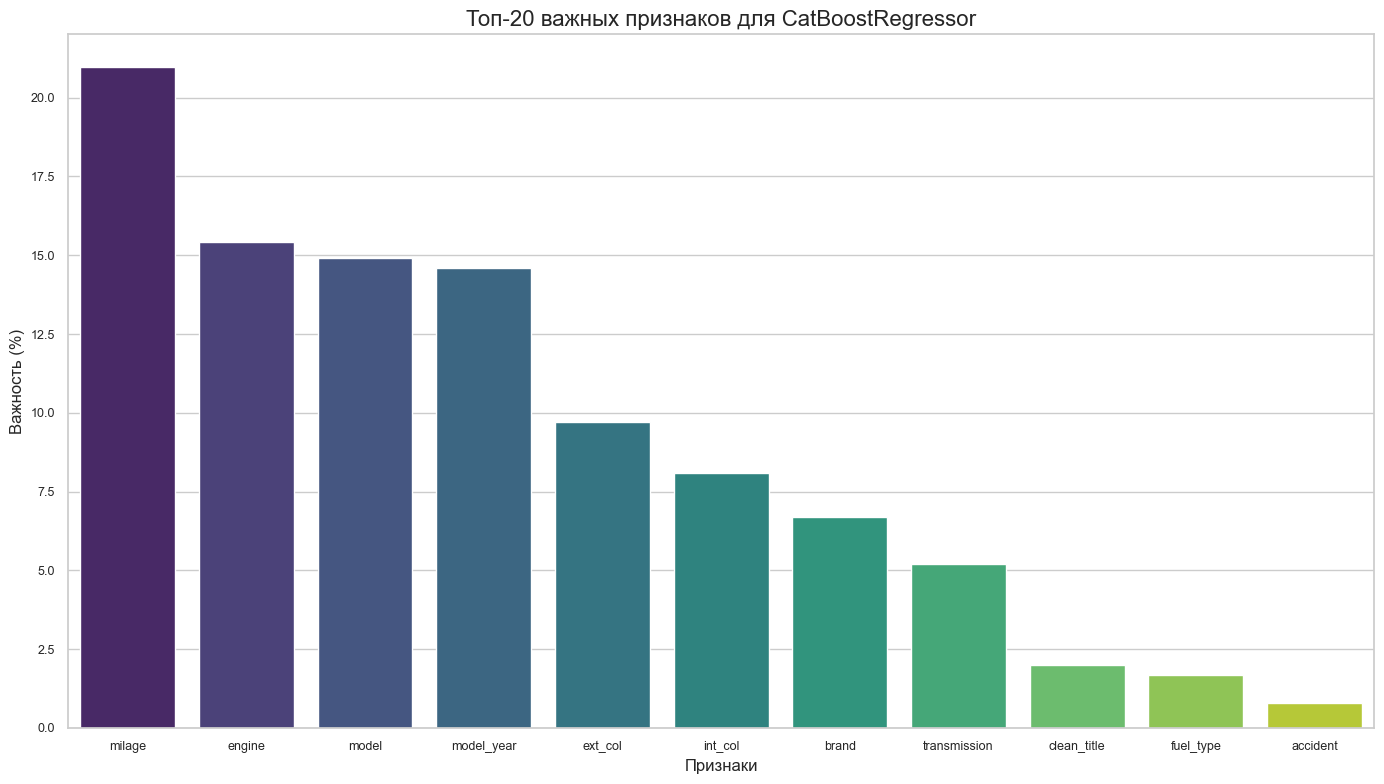

In [110]:
# Получение важности признаков
feature_importances = cb_model.get_feature_importance()

# Преобразование важности в проценты
importance_percentage = 100 * (feature_importances / feature_importances.sum())

# Создание DataFrame с именами признаков и их процентной важностью
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Признак': feature_names,
    'Важность (%)': importance_percentage
})

# Сортировка признаков по убыванию важности
importance_df = importance_df.sort_values(by='Важность (%)', ascending=False)

sns.set(style="whitegrid")

# Создание графика
plt.figure(figsize=(14, 8))
sns.barplot(x='Признак', y='Важность (%)', data=importance_df, palette='viridis')

# Настройка заголовков и меток осей
plt.title("Топ-20 важных признаков для CatBoostRegressor", fontsize=16)
plt.xlabel("Признаки", fontsize=12)
plt.ylabel("Важность (%)", fontsize=12)

# Поворот меток оси X на 90 градусов для лучшей читаемости
plt.xticks(rotation=0, fontsize=9)
plt.yticks(fontsize=9)

# Автоматическое выравнивание элементов графика
plt.tight_layout()

# Отображение графика
plt.show()

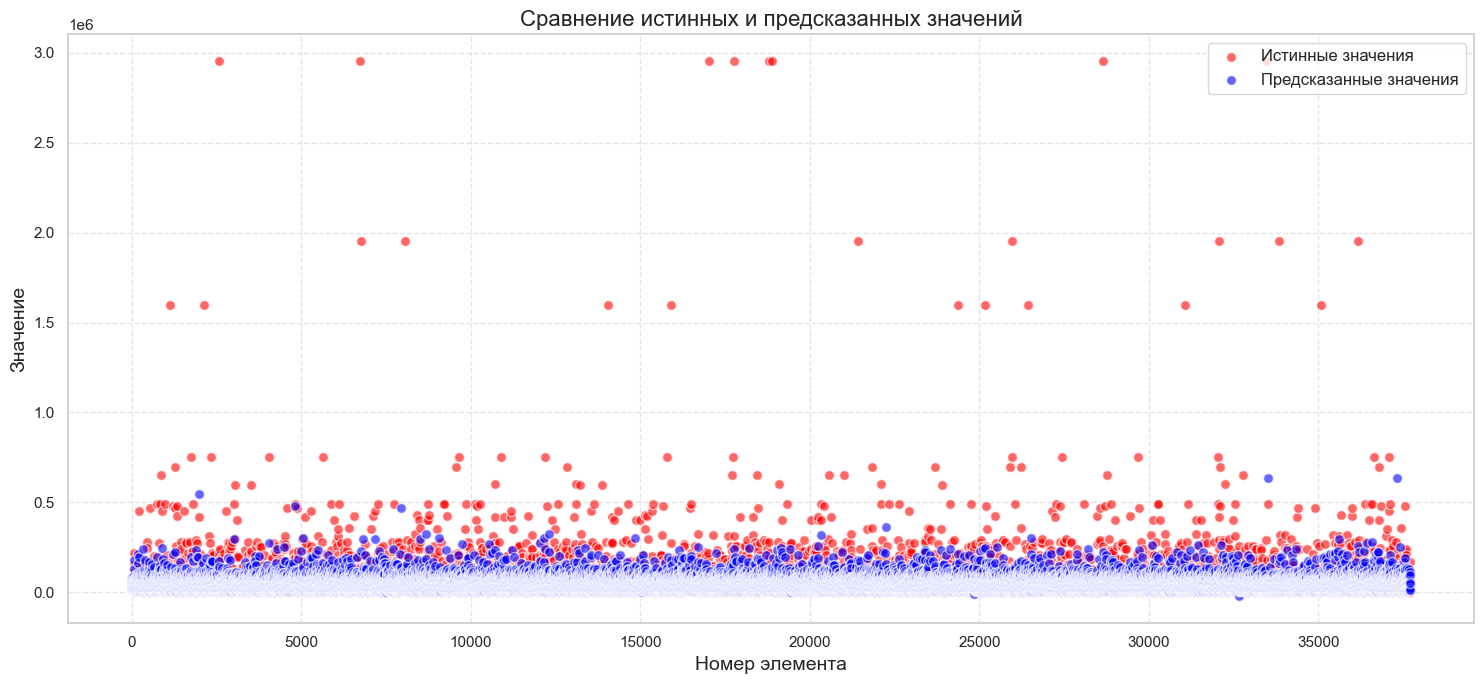

In [111]:
def plot_y_test_vs_y_pred(y_test, y_pred, title='True vs Predicted Values'):
    """
    Строит график с истинными значениями (y_test) и предсказанными значениями (y_pred).

    Параметры:
    - y_test: array-like или pandas Series, истинные значения.
    - y_pred: array-like или pandas Series, предсказанные значения.
    - title: str, заголовок графика.
    """
    # Преобразование pandas Series в numpy массивы, если необходимо
    if isinstance(y_test, pd.Series):
        y_test = y_test.values
    if isinstance(y_pred, pd.Series):
        y_pred = y_pred.values

    # Проверка, что длины y_test и y_pred совпадают
    if len(y_test) != len(y_pred):
        raise ValueError("Длины y_test и y_pred должны совпадать.")

    # Создание массива индексов для оси X
    x = np.arange(len(y_test))

    plt.figure(figsize=(15, 7))

    # Построение истинных значений (красные точки)
    plt.scatter(x, y_test, color='red', label='Истинные значения', alpha=0.6, edgecolors='w', s=50)

    # Построение предсказанных значений (синие точки)
    plt.scatter(x, y_pred, color='blue', label='Предсказанные значения', alpha=0.6, edgecolors='w', s=50)

    # Добавление линии тренда для истинных и предсказанных значений (опционально)
    # plt.plot(x, y_test, color='red', linestyle='-', alpha=0.5)
    # plt.plot(x, y_pred, color='blue', linestyle='--', alpha=0.5)

    # Добавление меток и заголовка
    plt.xlabel('Номер элемента', fontsize=14)
    plt.ylabel('Значение', fontsize=14)
    plt.title(title, fontsize=16)

    # Добавление легенды
    plt.legend(fontsize=12)

    # Добавление сетки для лучшей читаемости
    plt.grid(True, linestyle='--', alpha=0.5)

    # Опционально: Ограничение диапазона по оси X, если слишком много точек
    # plt.xlim(0, len(y_test))

    # Автоматическое расположение элементов для предотвращения наложения
    plt.tight_layout()

    # Отображение графика
    plt.show()

# Пример использования:
# Предположим, что y_test и y_pred уже определены после обучения модели



# Вызов функции для построения графика
plot_y_test_vs_y_pred(y_test, cb_predictions, title='Сравнение истинных и предсказанных значений')

# LGBM

In [112]:
# Обучение модели LightGBM
lgb_model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6, random_state=42)
lgb_model.fit(X_train_encoded,
                y_train,
                eval_set=[(X_test_encoded, y_test)],
                callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(10)])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1254
[LightGBM] [Info] Number of data points in the train set: 150826, number of used features: 11
[LightGBM] [Info] Start training from score 43890.785316
Training until validation scores don't improve for 50 rounds
[10]	valid_0's l2: 4.98689e+09
[20]	valid_0's l2: 4.77785e+09
[30]	valid_0's l2: 4.70088e+09
[40]	valid_0's l2: 4.67339e+09
[50]	valid_0's l2: 4.66581e+09
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	valid_0's l2: 4.66472e+09
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	valid_0's l2: 4.6671e+09
[LightGBM] [

LGBMRegressor(learning_rate=0.05, max_depth=6, n_estimators=1000,
              random_state=42)

In [113]:
# Предсказания для LightGBM
lgb_predictions = lgb_model.predict(X_test_encoded)
lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_predictions))
print(f'RMSE для LightGBM: {lgb_rmse}')

RMSE для LightGBM: 68284.76952550131


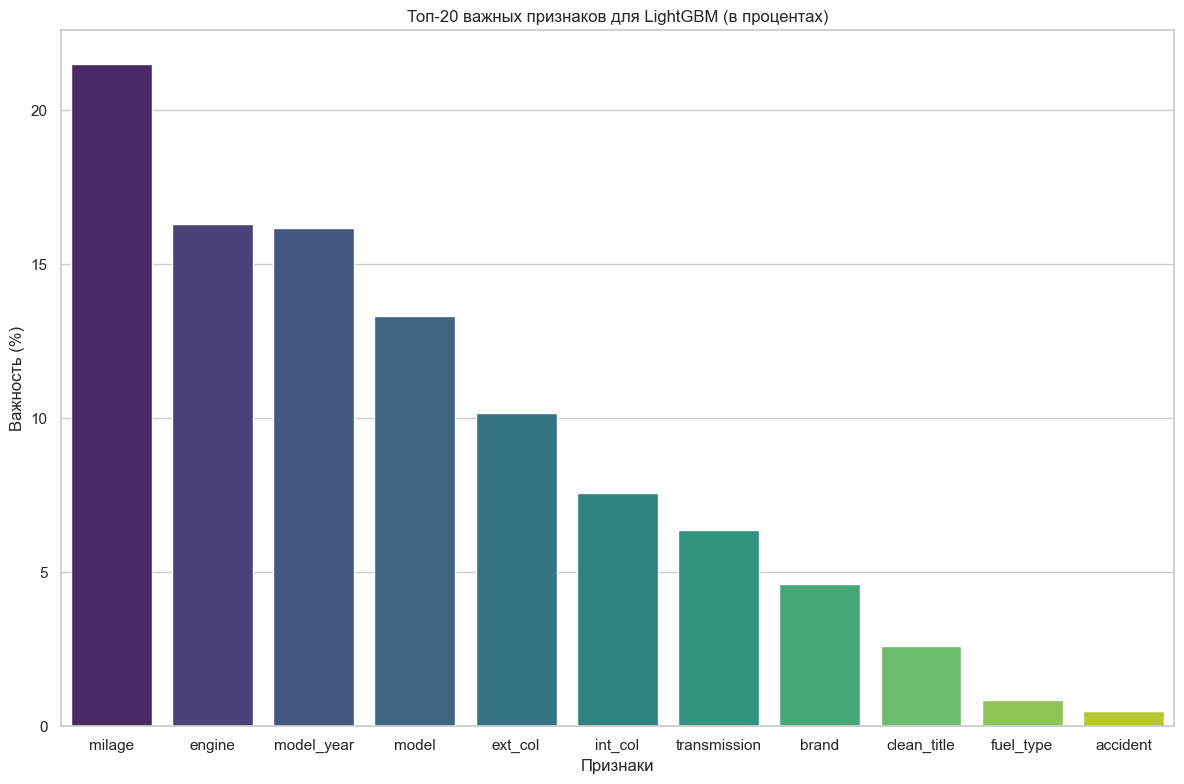

In [114]:
# Получение важности признаков
feature_importances = lgb_model.feature_importances_
feature_names = X_train_encoded.columns

# Создание DataFrame с важностями признаков
importance_df = pd.DataFrame({
    'Признак': feature_names,
    'Важность': feature_importances
})

# Вычисление процентной важности
importance_df['Важность (%)'] = 100 * (importance_df['Важность'] / importance_df['Важность'].sum())

# Сортировка признаков по убыванию процентной важности
importance_df = importance_df.sort_values(by='Важность (%)', ascending=False)


# Отображение важности признаков в процентах
plt.figure(figsize=(12, 8))
sns.barplot(x='Признак', y='Важность (%)', data=importance_df, palette='viridis')


plt.title("Топ-20 важных признаков для LightGBM (в процентах)")
plt.xlabel("Признаки")
plt.ylabel("Важность (%)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

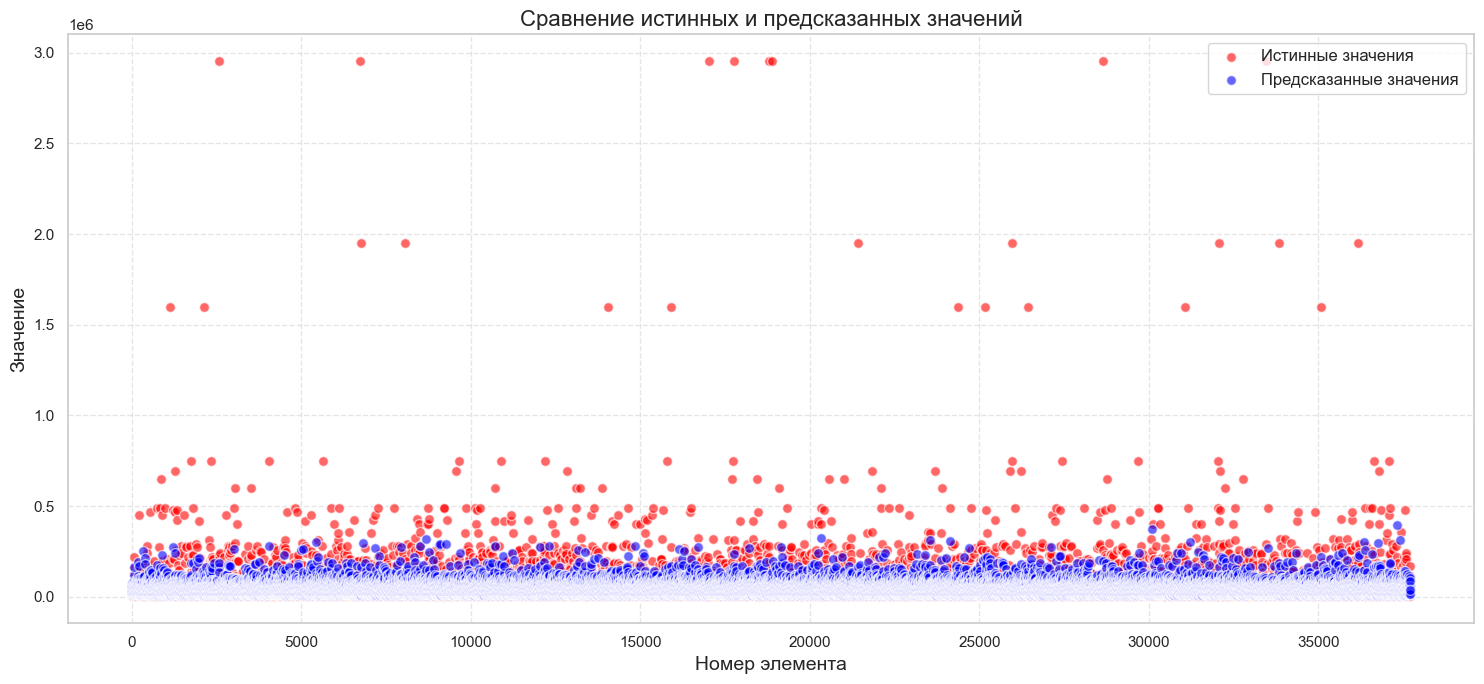

In [115]:
# Вызов функции для построения графика
plot_y_test_vs_y_pred(y_test, lgb_predictions, title='Сравнение истинных и предсказанных значений')

# XGBoost

In [116]:
print(xgb.__version__)

2.1.1


In [117]:
# Инициализация модели
xgb_model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=8,
    random_state=42,
    early_stopping_rounds=100
)

# Обучение модели с ранней остановкой
xgb_model.fit(
    X_train_encoded, y_train,
    eval_set=[(X_test_encoded, y_test)],
    # early_stopping_rounds=100,  # Используем правильный параметр
    verbose=True
)

[0]	validation_0-rmse:73978.40083
[1]	validation_0-rmse:73445.06674
[2]	validation_0-rmse:72955.40026
[3]	validation_0-rmse:72519.43637
[4]	validation_0-rmse:72141.49090
[5]	validation_0-rmse:71795.76155
[6]	validation_0-rmse:71510.69717
[7]	validation_0-rmse:71250.82893
[8]	validation_0-rmse:71029.46070
[9]	validation_0-rmse:70803.16462


[10]	validation_0-rmse:70626.40472
[11]	validation_0-rmse:70474.72052
[12]	validation_0-rmse:70306.02064
[13]	validation_0-rmse:70178.94592
[14]	validation_0-rmse:70047.80282
[15]	validation_0-rmse:69933.18808
[16]	validation_0-rmse:69838.70919
[17]	validation_0-rmse:69752.42765
[18]	validation_0-rmse:69671.20113
[19]	validation_0-rmse:69610.08373
[20]	validation_0-rmse:69562.54193
[21]	validation_0-rmse:69540.47854
[22]	validation_0-rmse:69509.55784
[23]	validation_0-rmse:69486.31639
[24]	validation_0-rmse:69495.59925
[25]	validation_0-rmse:69496.66994
[26]	validation_0-rmse:69498.90421
[27]	validation_0-rmse:69461.84299
[28]	validation_0-rmse:69473.11076
[29]	validation_0-rmse:69486.42387
[30]	validation_0-rmse:69515.86413
[31]	validation_0-rmse:69528.14748
[32]	validation_0-rmse:69555.50135
[33]	validation_0-rmse:69561.10168
[34]	validation_0-rmse:69584.69521
[35]	validation_0-rmse:69591.66290
[36]	validation_0-rmse:69572.52574
[37]	validation_0-rmse:69576.59014
[38]	validation_0-rm

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [118]:
# Предсказания для XGBoost
xgb_predictions = xgb_model.predict(X_test_encoded)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
print(f'RMSE для XGBoost: {xgb_rmse}')

RMSE для XGBoost: 69461.84283260444


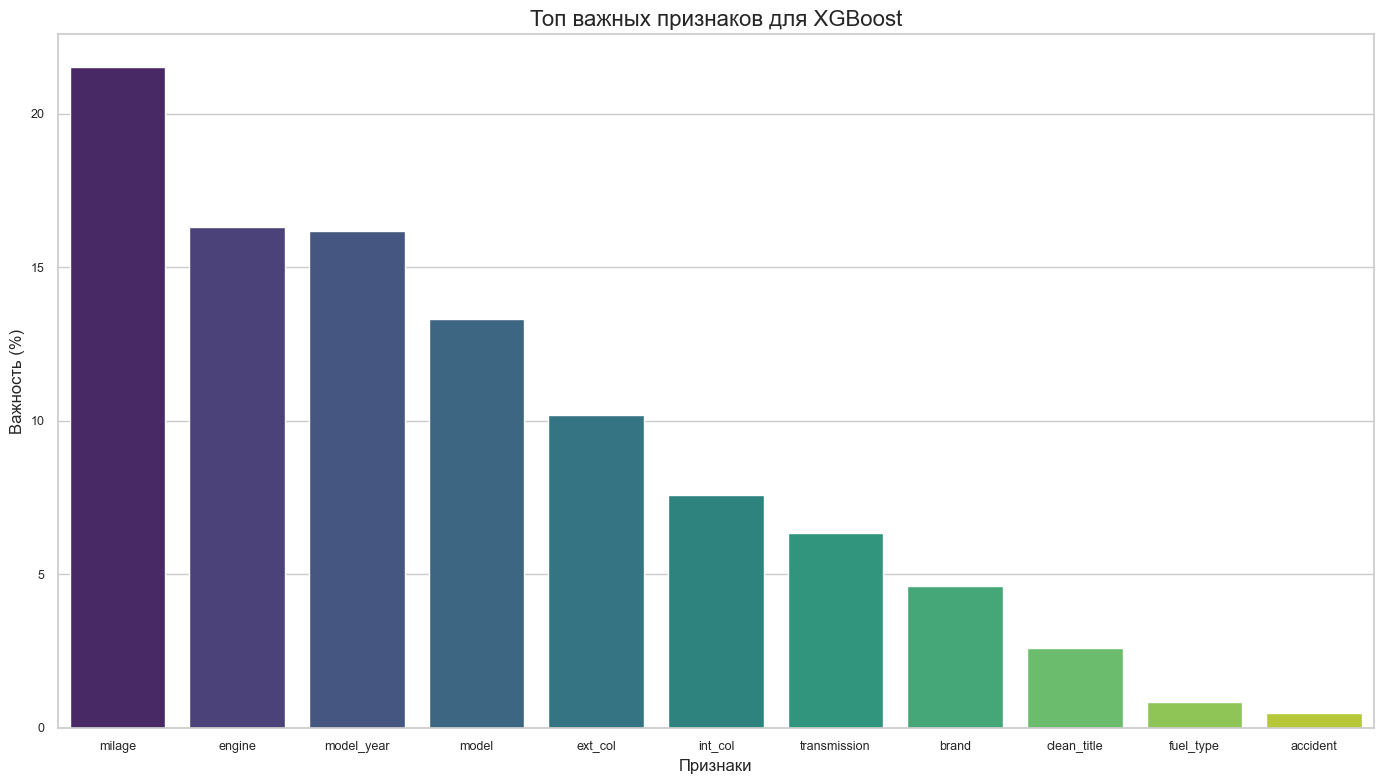

In [119]:
# Получение важности признаков
feature_importances = lgb_model.feature_importances_
feature_names = X_train_encoded.columns

# Создание DataFrame с важностями признаков
importance_df = pd.DataFrame({
    'Признак': feature_names,
    'Важность': feature_importances
})

# Вычисление процентной важности
importance_df['Важность (%)'] = 100 * (importance_df['Важность'] / importance_df['Важность'].sum())

# Сортировка признаков по убыванию процентной важности
importance_df = importance_df.sort_values(by='Важность (%)', ascending=False)


# Отображение важности признаков в процентах с вертикальными столбцами
plt.figure(figsize=(14, 8))
sns.barplot(x='Признак', y='Важность (%)', data=importance_df, palette='viridis')


plt.title("Топ важных признаков для XGBoost", fontsize=16)
plt.xlabel("Признаки", fontsize=12)
plt.ylabel("Важность (%)", fontsize=12)
plt.xticks(rotation=0, fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()

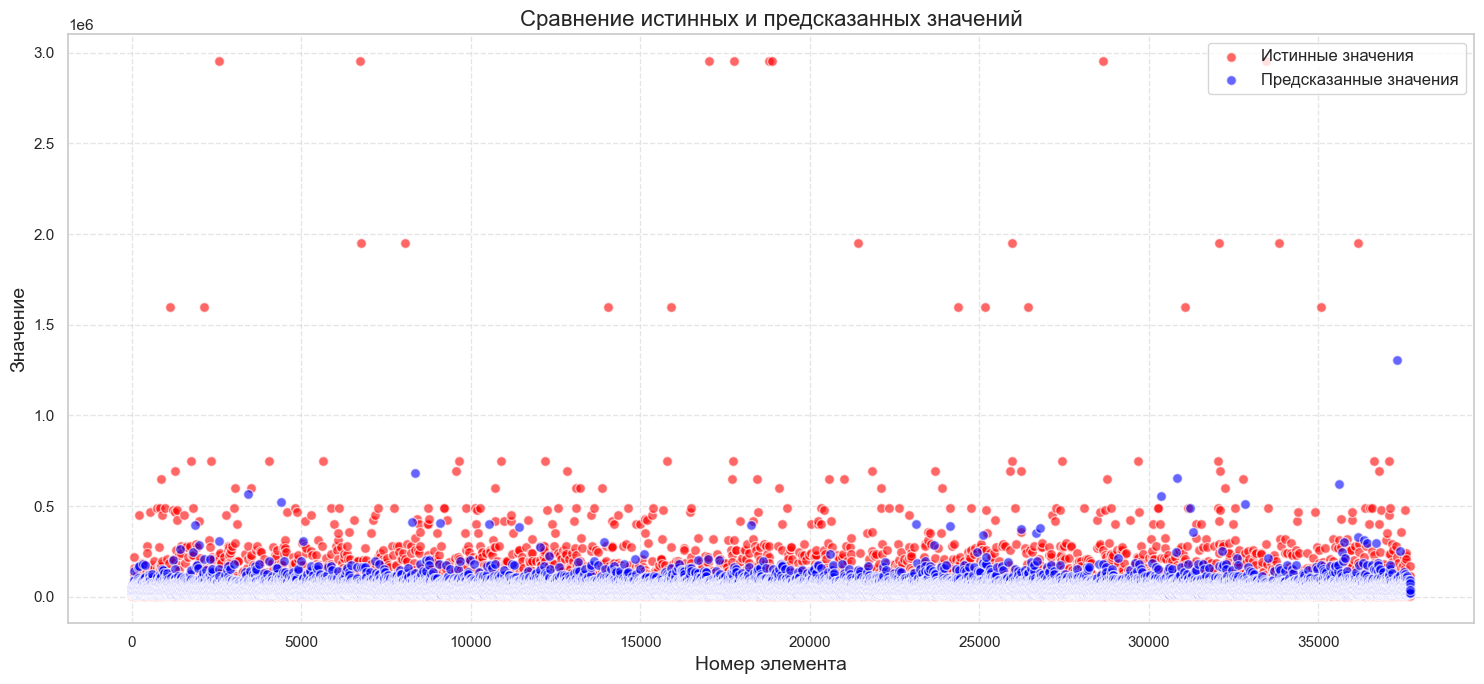

In [120]:
# Вызов функции для построения графика
plot_y_test_vs_y_pred(y_test, xgb_predictions, title='Сравнение истинных и предсказанных значений')

# Linear Regression

In [121]:
lr_model = LinearRegression()
lr_model.fit(X_train_encoded, y_train)

LinearRegression()

In [122]:
# Предсказания для XGBoost
lr_predictions = lr_model.predict(X_test_encoded)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_predictions))
print(f'RMSE для LinearRegression: {lr_rmse}')

RMSE для LinearRegression: 68776.1761427296


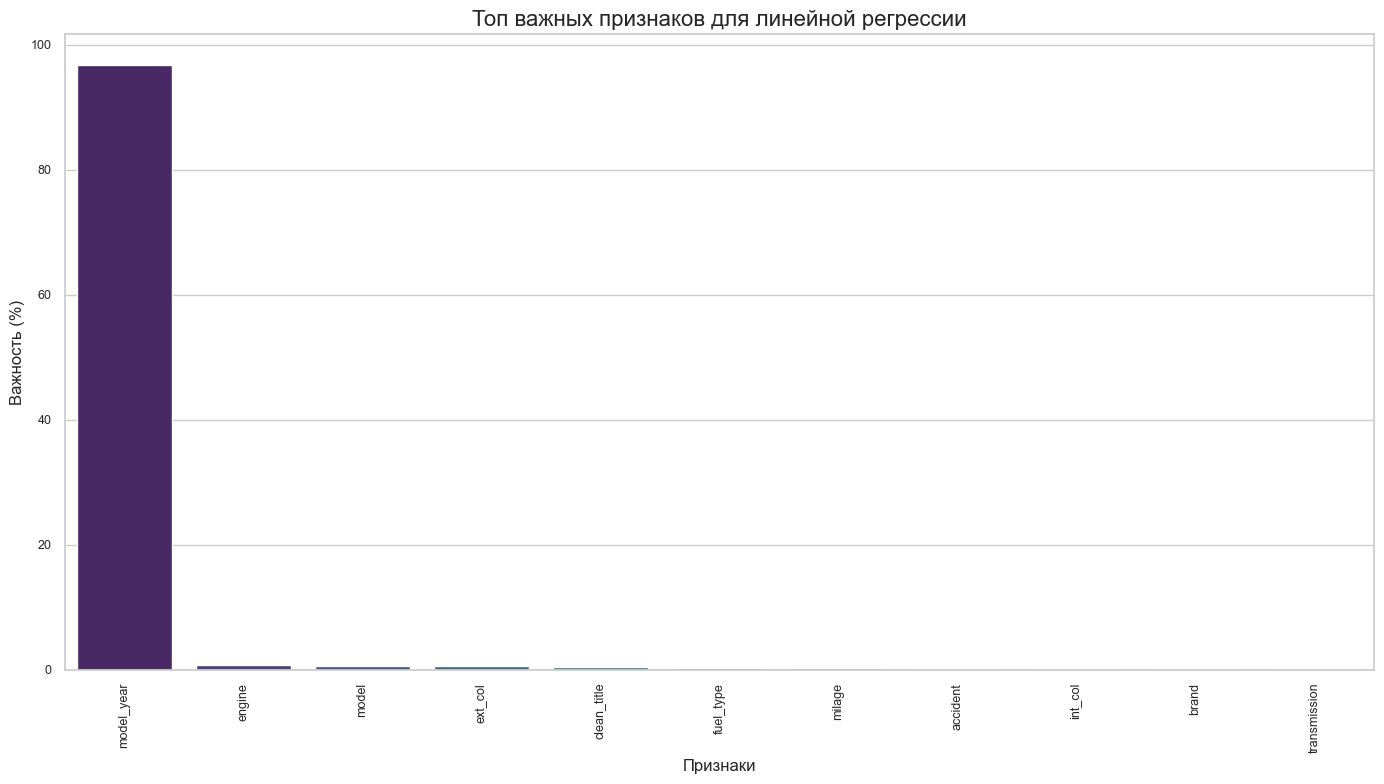

In [123]:
# Получение коэффициентов модели
coefficients = lr_model.coef_

# Вычисление абсолютных значений коэффициентов для важности
importance = np.abs(coefficients)

# Преобразование важности в проценты
importance_percentage = 100 * (importance / importance.sum())

# Создание DataFrame с именами признаков и их процентной важностью
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Признак': feature_names,
    'Важность (%)': importance_percentage
})

# Сортировка признаков по убыванию важности
importance_df = importance_df.sort_values(by='Важность (%)', ascending=False)


# Построение вертикального столбчатого графика
plt.figure(figsize=(14, 8))
sns.barplot(x='Признак', y='Важность (%)', data=importance_df, palette='viridis')

plt.title("Топ важных признаков для линейной регрессии", fontsize=16)
plt.xlabel("Признаки", fontsize=12)
plt.ylabel("Важность (%)", fontsize=12)
plt.xticks(rotation=90, fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()

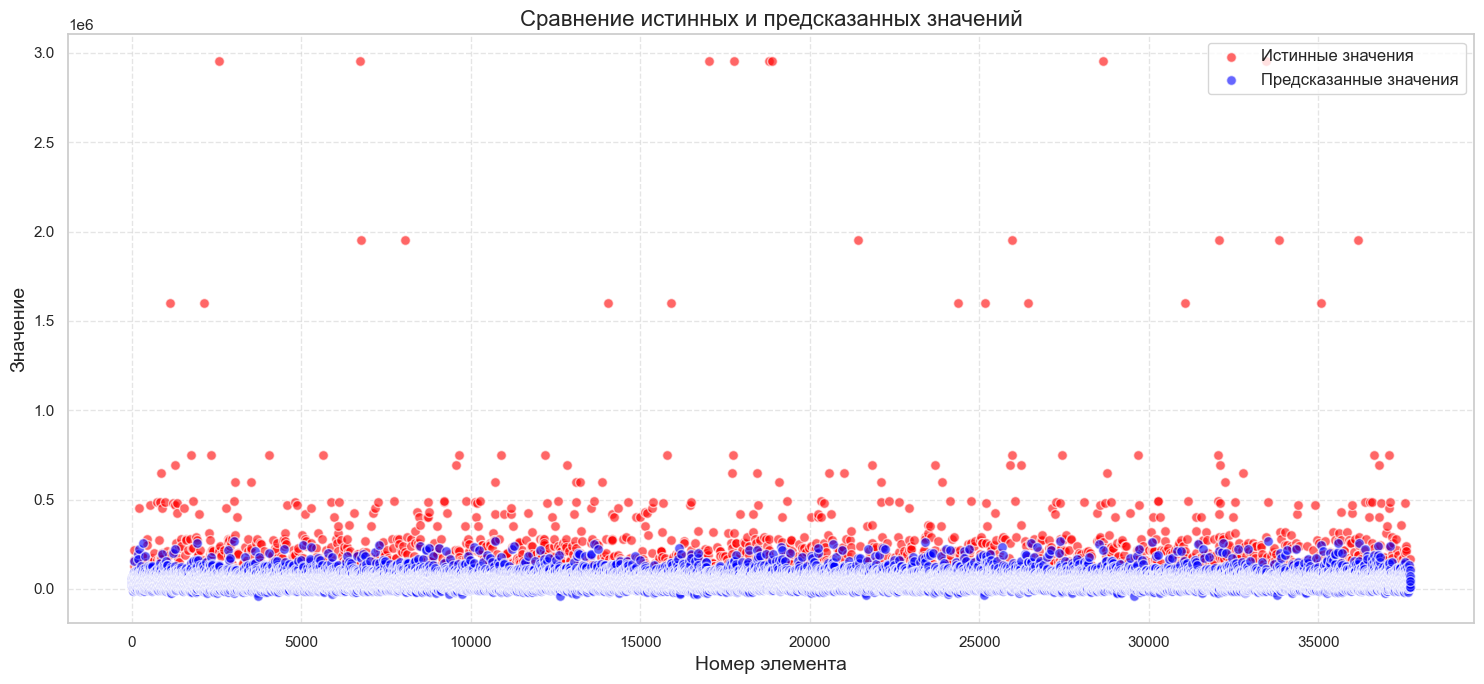

In [124]:
# Вызов функции для построения графика
plot_y_test_vs_y_pred(y_test, lr_predictions, title='Сравнение истинных и предсказанных значений')

# Ridge

In [125]:
ridge_model = Ridge()
ridge_model.fit(X_train_encoded, y_train)

Ridge()

In [126]:
# Предсказания для XGBoost
ridge_predictions = ridge_model.predict(X_test_encoded)
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_predictions))
print(f'RMSE для Ridge: {ridge_rmse}')

RMSE для Ridge: 68776.17614113222


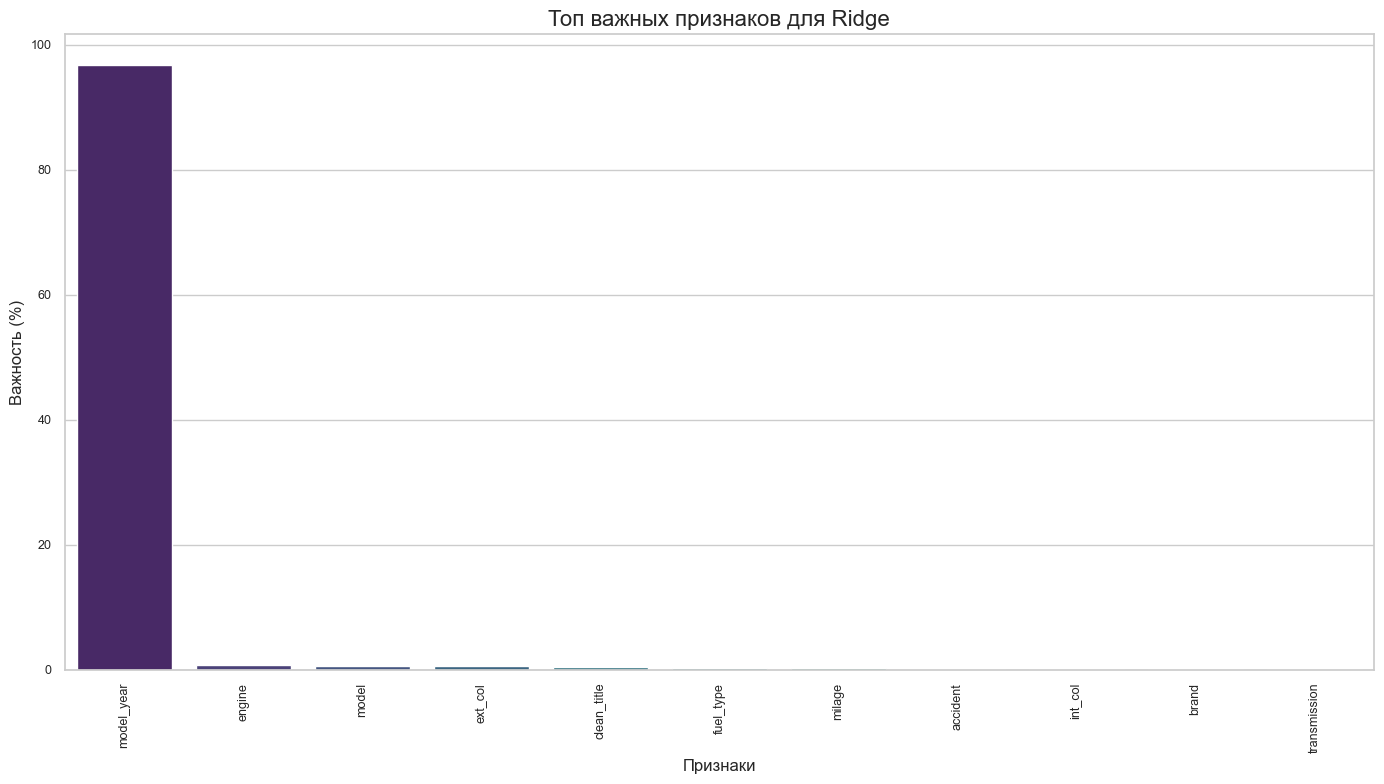

In [127]:
# 3. Получение коэффициентов модели
coefficients = ridge_model.coef_

# 4. Вычисление абсолютных значений коэффициентов для важности
importance = np.abs(coefficients)

# 5. Преобразование важности в проценты
importance_percentage = 100 * (importance / importance.sum())

# Создание DataFrame с именами признаков и их процентной важностью
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Признак': feature_names,
    'Важность (%)': importance_percentage
})

# Сортировка признаков по убыванию важности
importance_df = importance_df.sort_values(by='Важность (%)', ascending=False)


# 6. Построение вертикального столбчатого графика
plt.figure(figsize=(14, 8))
sns.barplot(x='Признак', y='Важность (%)', data=importance_df, palette='viridis')

plt.title("Топ важных признаков для Ridge", fontsize=16)
plt.xlabel("Признаки", fontsize=12)
plt.ylabel("Важность (%)", fontsize=12)
plt.xticks(rotation=90, fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()

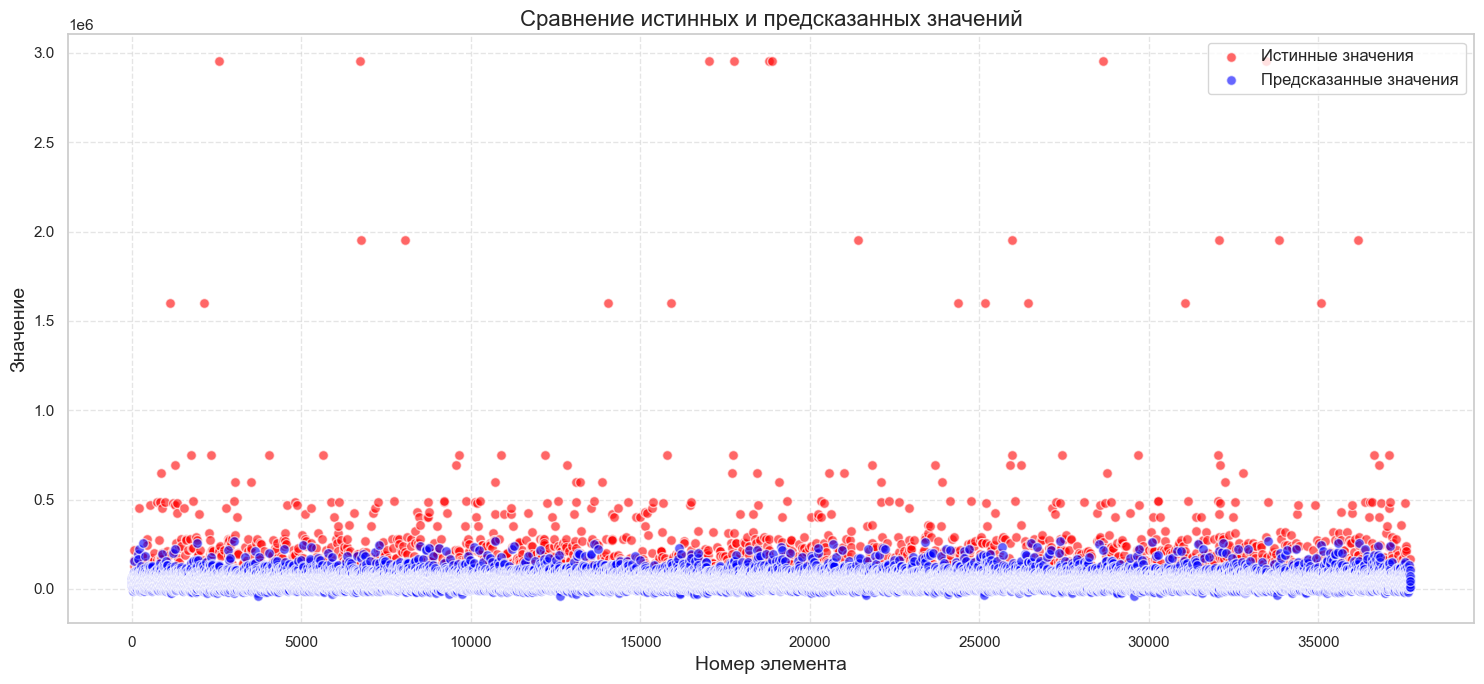

In [128]:
# Вызов функции для построения графика
plot_y_test_vs_y_pred(y_test, ridge_predictions, title='Сравнение истинных и предсказанных значений')

# RandomForest

In [129]:

rf_model = RandomForestRegressor(
    n_estimators=100,          # Количество деревьев в лесу
    max_depth=None,            # Максимальная глубина дерева
    random_state=42,           # Для воспроизводимости результатов
    n_jobs=-1                  # Использовать все доступные ядра процессора
)
rf_model.fit(X_train_encoded, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [130]:
# Предсказания для RandomForestRegressor
rf_predictions = rf_model.predict(X_test_encoded)

# Оценка модели с использованием RMSE
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
print(f'RMSE для RandomForestRegressor: {rf_rmse}')

RMSE для RandomForestRegressor: 74138.14152929735


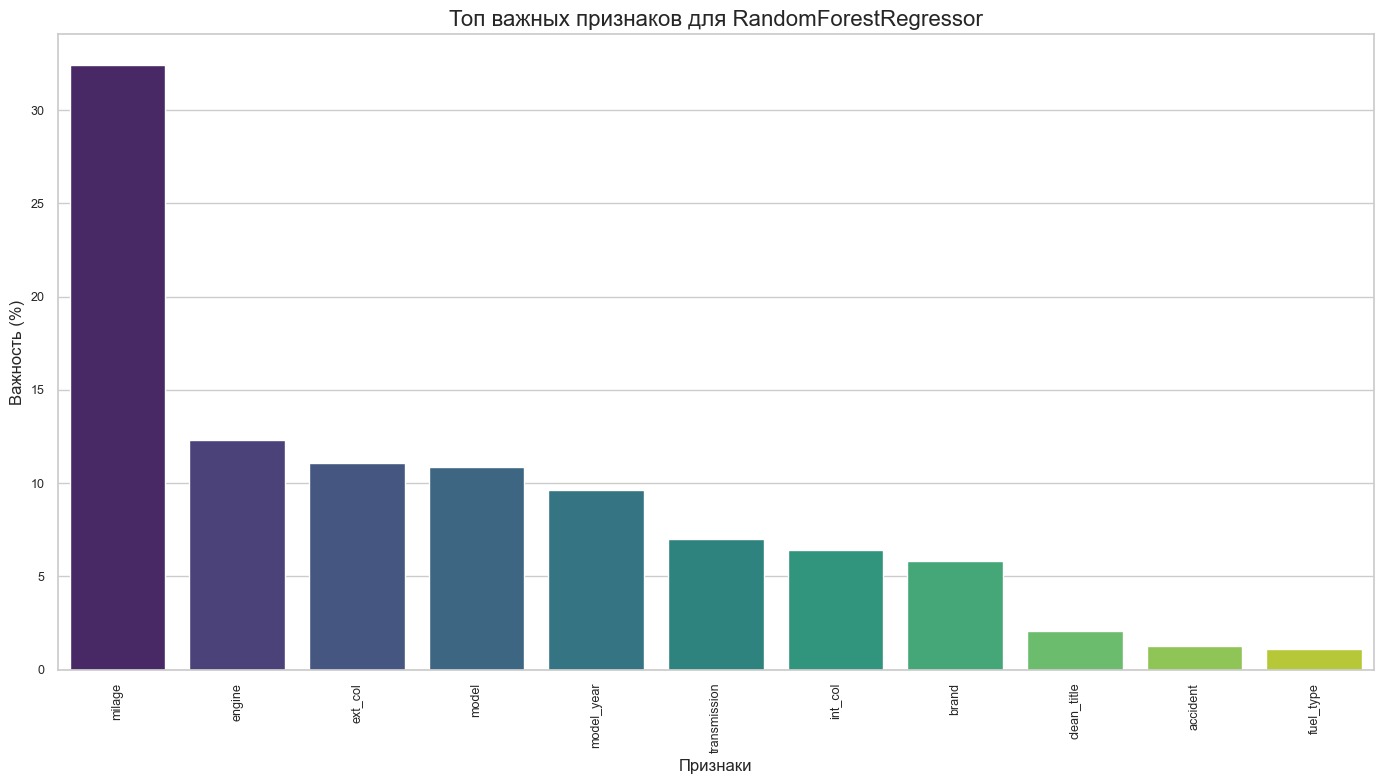

In [131]:
# Получение важности признаков
feature_importances = rf_model.feature_importances_

# Преобразование важности в проценты
importance_percentage = 100 * (feature_importances / feature_importances.sum())

# Создание DataFrame с именами признаков и их процентной важностью
feature_names = X_train_encoded.columns
importance_df = pd.DataFrame({
    'Признак': feature_names,
    'Важность (%)': importance_percentage
})

# Сортировка признаков по убыванию важности
importance_df = importance_df.sort_values(by='Важность (%)', ascending=False)


# Построение вертикального столбчатого графика
plt.figure(figsize=(14, 8))
sns.barplot(x='Признак', y='Важность (%)', data=importance_df, palette='viridis')



plt.title("Топ важных признаков для RandomForestRegressor", fontsize=16)
plt.xlabel("Признаки", fontsize=12)
plt.ylabel("Важность (%)", fontsize=12)
plt.xticks(rotation=90, fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()

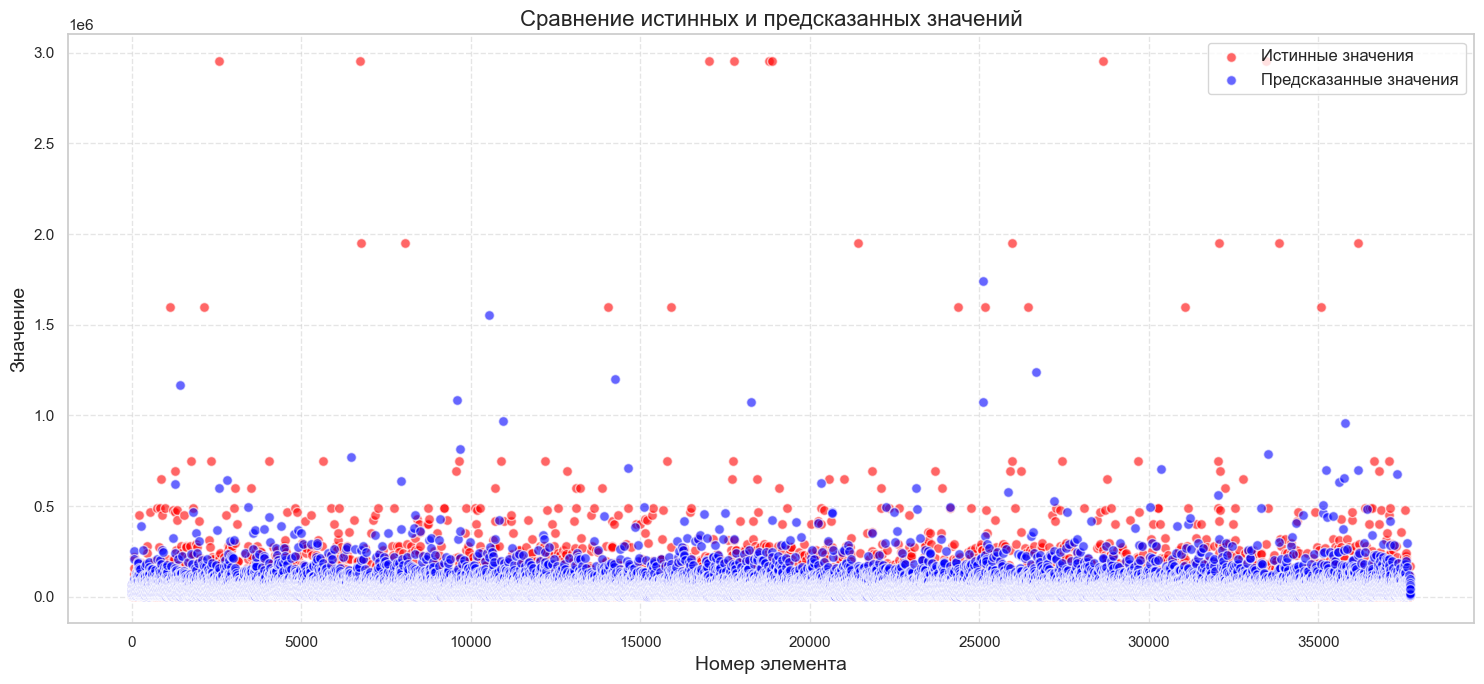

In [132]:
# Вызов функции для построения графика
plot_y_test_vs_y_pred(y_test, rf_predictions, title='Сравнение истинных и предсказанных значений')

# Stacking

## 1.Метамодель - Линейная Регрессия

In [133]:
# Инициализация мета-модели
meta_model_lr = LinearRegression()

### 1.1. Оригинальные признаки передаются модели

In [134]:
# Список базовых моделей для стекинга
estimators = [
    ('cb',cb_model),
    ('lgbm', lgb_model),
    ('lr', lr_model),
    # ('xgb', xgb_model),
    ('rf', rf_model)
]

# Создание стекинг-регрессора
stacking_regressor = StackingRegressor(
    estimators=estimators,
    final_estimator=meta_model_lr,
    cv=5,            # Количество фолдов для кросс-валидации
    n_jobs=-1,       # Использовать все доступные ядра процессора
    passthrough=True # Если True, оригинальные признаки будут переданы мета-модели
)

# Обучение стекинг-регрессора
stacking_regressor.fit(X_train_encoded, y_train)

0:	learn: 79526.7362468	total: 61ms	remaining: 1m
1:	learn: 79219.5197007	total: 69.6ms	remaining: 34.7s
2:	learn: 78939.6440897	total: 84.6ms	remaining: 28.1s
3:	learn: 78669.6493966	total: 95.8ms	remaining: 23.8s
4:	learn: 78413.1747267	total: 109ms	remaining: 21.7s
5:	learn: 78166.1078572	total: 121ms	remaining: 20s
6:	learn: 77928.2463377	total: 143ms	remaining: 20.3s
7:	learn: 77709.2111144	total: 155ms	remaining: 19.2s
8:	learn: 77501.5272535	total: 162ms	remaining: 17.9s
9:	learn: 77300.0742275	total: 171ms	remaining: 16.9s
10:	learn: 77108.5675268	total: 198ms	remaining: 17.8s
11:	learn: 76928.0835784	total: 215ms	remaining: 17.7s
12:	learn: 76754.7171004	total: 233ms	remaining: 17.7s
13:	learn: 76592.2663153	total: 259ms	remaining: 18.3s
14:	learn: 76430.5795496	total: 275ms	remaining: 18s
15:	learn: 76280.7652736	total: 297ms	remaining: 18.3s
16:	learn: 76140.1748374	total: 341ms	remaining: 19.7s
17:	learn: 76005.1917802	total: 358ms	remaining: 19.6s
18:	learn: 75873.6023555	

StackingRegressor(cv=5,
                  estimators=[('cb',
                               <catboost.core.CatBoostRegressor object at 0x1745fb750>),
                              ('lgbm',
                               LGBMRegressor(learning_rate=0.05, max_depth=6,
                                             n_estimators=1000,
                                             random_state=42)),
                              ('lr', LinearRegression()),
                              ('rf',
                               RandomForestRegressor(n_jobs=-1,
                                                     random_state=42))],
                  final_estimator=LinearRegression(), n_jobs=-1,
                  passthrough=True)

In [135]:
# Предсказания стекинг-модели
stacking_predictions = stacking_regressor.predict(X_test_encoded)

# Вычисление RMSE для стекинг-модели
stacking_rmse = np.sqrt(mean_squared_error(y_test, stacking_predictions))
print(f'RMSE для стекинг-модели: {stacking_rmse:.4f}')

RMSE для стекинг-модели: 68235.1174


Коэффициенты мета-модели (LinearRegression): [ 2.53291721e-01  1.35871003e-01 -4.40187857e+00  7.44758483e-02
  2.32409274e-01  1.80500612e+00 -2.81651334e+02 -1.03503524e+00
 -1.09091482e+00  2.26431148e+00  1.16444967e-01  1.62477094e+00
  4.02626496e-01  4.41499266e-01 -1.27838383e+00]


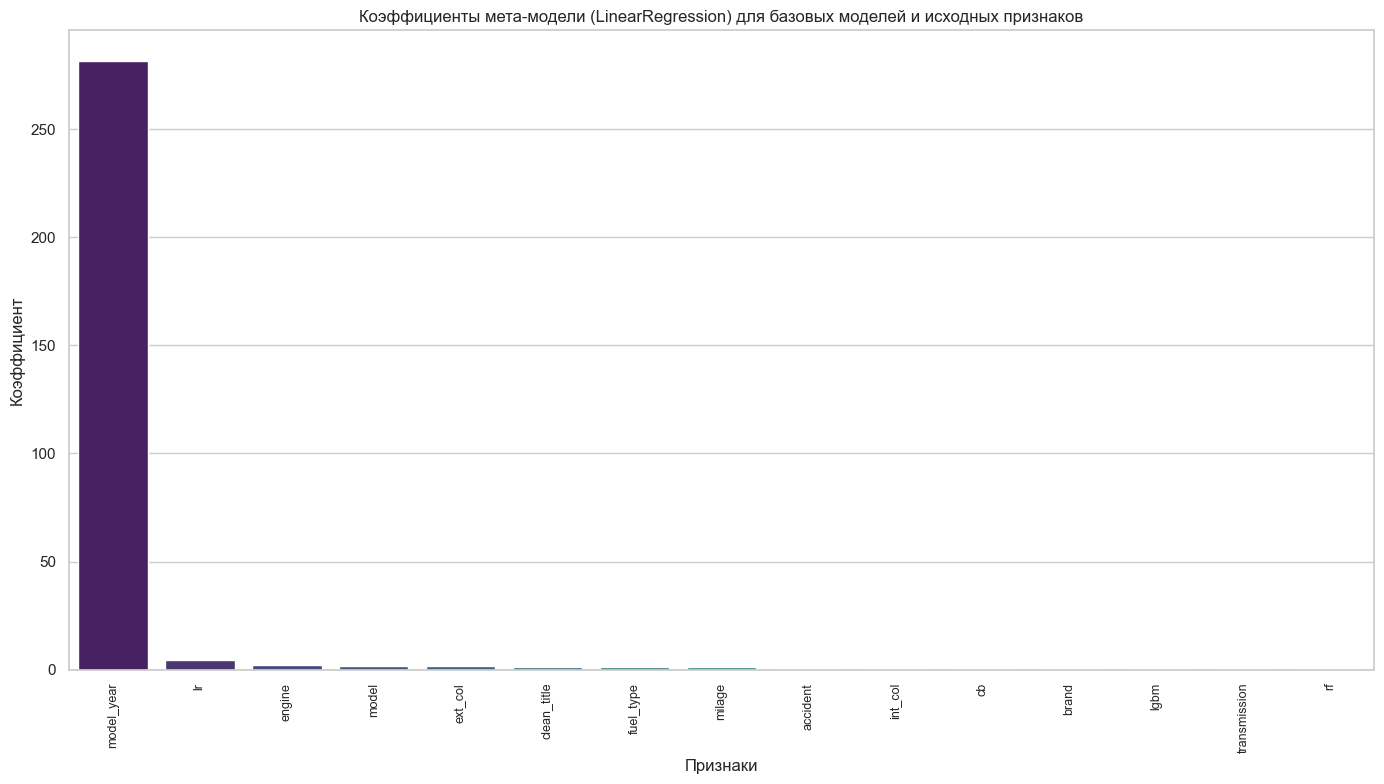

In [136]:
# Доступ к мета-модели и её коэффициентам
if hasattr(stacking_regressor.final_estimator_, 'coef_'):
    meta_coef = stacking_regressor.final_estimator_.coef_
    print("Коэффициенты мета-модели (LinearRegression):", meta_coef)

    # Получение имен базовых моделей
    base_model_names = list(stacking_regressor.named_estimators_.keys())

    # Получение имен исходных признаков
    original_feature_names = X_train.columns.tolist()

    # Объединение имен базовых моделей и исходных признаков
    feature_names = base_model_names + original_feature_names


    # Создание DataFrame для коэффициентов
    coef_df = pd.DataFrame({
        'Признак': feature_names,
        'Коэффициент': meta_coef
    })

    # Сортировка по абсолютному значению коэффициентов
    coef_df['Абсолютный коэффициент'] = coef_df['Коэффициент'].abs()
    coef_df = coef_df.sort_values(by='Абсолютный коэффициент', ascending=False).head(20)

    # Визуализация коэффициентов
    plt.figure(figsize=(14, 8))
    sns.barplot(x='Признак', y='Абсолютный коэффициент', data=coef_df, palette='viridis')

    plt.title("Коэффициенты мета-модели (LinearRegression) для базовых моделей и исходных признаков")
    plt.xlabel("Признаки")
    plt.ylabel("Коэффициент")
    plt.xticks(rotation=90, fontsize=9)
    plt.tight_layout()
    plt.show()
else:
    print("Мета-модель не имеет атрибута 'coef_'.")

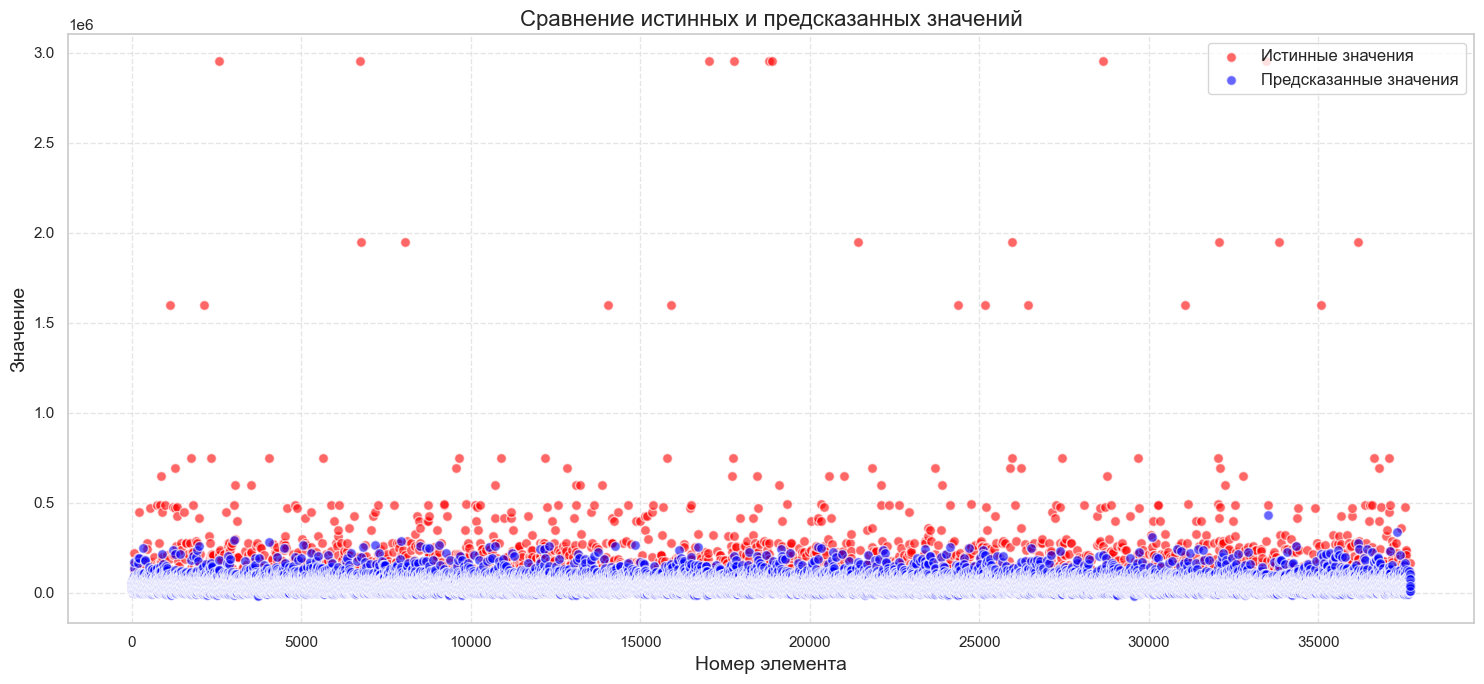

In [137]:
# Вызов функции для построения графика
plot_y_test_vs_y_pred(y_test, stacking_predictions, title='Сравнение истинных и предсказанных значений')

### 1.2 Оригинальные признаки модели не передаются

In [138]:
# Список базовых моделей для стекинга
estimators = [
    ('cb',cb_model),
    ('lgbm', lgb_model),
    ('lr', lr_model),
    # ('xgb', xgb_model),
    ('rf', rf_model)
]

# Создание стекинг-регрессора
stacking_regressor = StackingRegressor(
    estimators=estimators,
    final_estimator=meta_model_lr,
    cv=5,            # Количество фолдов для кросс-валидации
    n_jobs=-1,       # Использовать все доступные ядра процессора
    passthrough=False# Если True, оригинальные признаки будут переданы мета-модели
)

# Обучение стекинг-регрессора
stacking_regressor.fit(X_train_encoded, y_train)

0:	learn: 79526.7362468	total: 92.7ms	remaining: 1m 32s
1:	learn: 79219.5197007	total: 114ms	remaining: 57.1s
2:	learn: 78939.6440897	total: 143ms	remaining: 47.6s
3:	learn: 78669.6493966	total: 163ms	remaining: 40.6s
4:	learn: 78413.1747267	total: 176ms	remaining: 35s
5:	learn: 78166.1078572	total: 188ms	remaining: 31.1s
6:	learn: 77928.2463377	total: 200ms	remaining: 28.4s
7:	learn: 77709.2111144	total: 214ms	remaining: 26.5s
8:	learn: 77501.5272535	total: 226ms	remaining: 24.9s
9:	learn: 77300.0742275	total: 243ms	remaining: 24s
10:	learn: 77108.5675268	total: 258ms	remaining: 23.2s
11:	learn: 76928.0835784	total: 290ms	remaining: 23.9s
12:	learn: 76754.7171004	total: 309ms	remaining: 23.5s
13:	learn: 76592.2663153	total: 328ms	remaining: 23.1s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info

StackingRegressor(cv=5,
                  estimators=[('cb',
                               <catboost.core.CatBoostRegressor object at 0x1745fb750>),
                              ('lgbm',
                               LGBMRegressor(learning_rate=0.05, max_depth=6,
                                             n_estimators=1000,
                                             random_state=42)),
                              ('lr', LinearRegression()),
                              ('rf',
                               RandomForestRegressor(n_jobs=-1,
                                                     random_state=42))],
                  final_estimator=LinearRegression(), n_jobs=-1)

In [139]:
# Предсказания стекинг-модели
stacking_predictions = stacking_regressor.predict(X_test_encoded)

# Вычисление RMSE для стекинг-модели
stacking_rmse = np.sqrt(mean_squared_error(y_test, stacking_predictions))
print(f'RMSE для стекинг-модели: {stacking_rmse:.4f}')

RMSE для стекинг-модели: 68239.7707


Коэффициенты мета-модели (LinearRegression): [0.25289372 0.13755338 0.52673915 0.07334584]


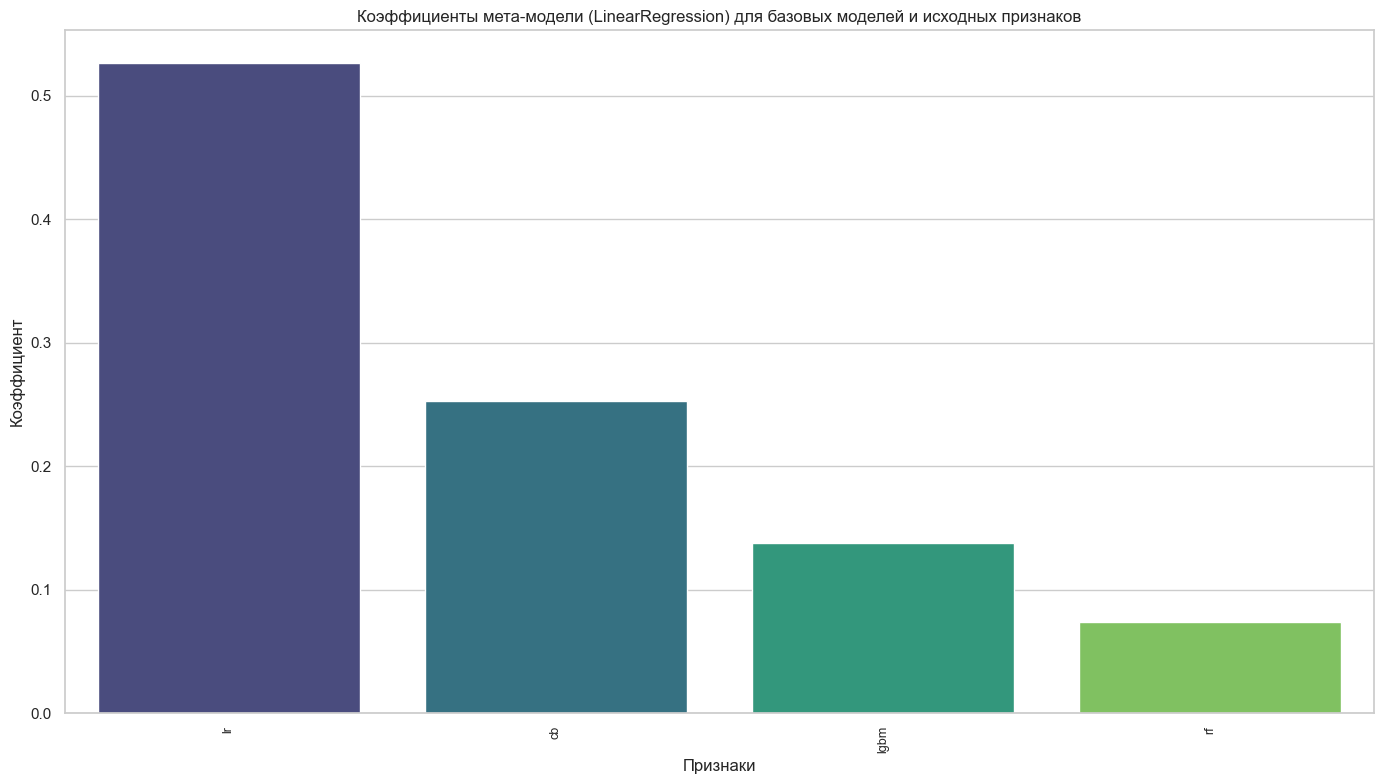

In [140]:
# Доступ к мета-модели и её коэффициентам
if hasattr(stacking_regressor.final_estimator_, 'coef_'):
    meta_coef = stacking_regressor.final_estimator_.coef_
    print("Коэффициенты мета-модели (LinearRegression):", meta_coef)

    # Получение имен базовых моделей
    feature_names = list(stacking_regressor.named_estimators_.keys())

    # Создание DataFrame для коэффициентов
    coef_df = pd.DataFrame({
        'Признак': feature_names,
        'Коэффициент': meta_coef
    })

    # Сортировка по абсолютному значению коэффициентов
    coef_df['Абсолютный коэффициент'] = coef_df['Коэффициент'].abs()
    coef_df = coef_df.sort_values(by='Абсолютный коэффициент', ascending=False).head(20)

    # Визуализация коэффициентов
    plt.figure(figsize=(14, 8))
    sns.barplot(x='Признак', y='Абсолютный коэффициент', data=coef_df, palette='viridis')

    plt.title("Коэффициенты мета-модели (LinearRegression) для базовых моделей и исходных признаков")
    plt.xlabel("Признаки")
    plt.ylabel("Коэффициент")
    plt.xticks(rotation=90, fontsize=9)
    plt.tight_layout()
    plt.show()
else:
    print("Мета-модель не имеет атрибута 'coef_'.")

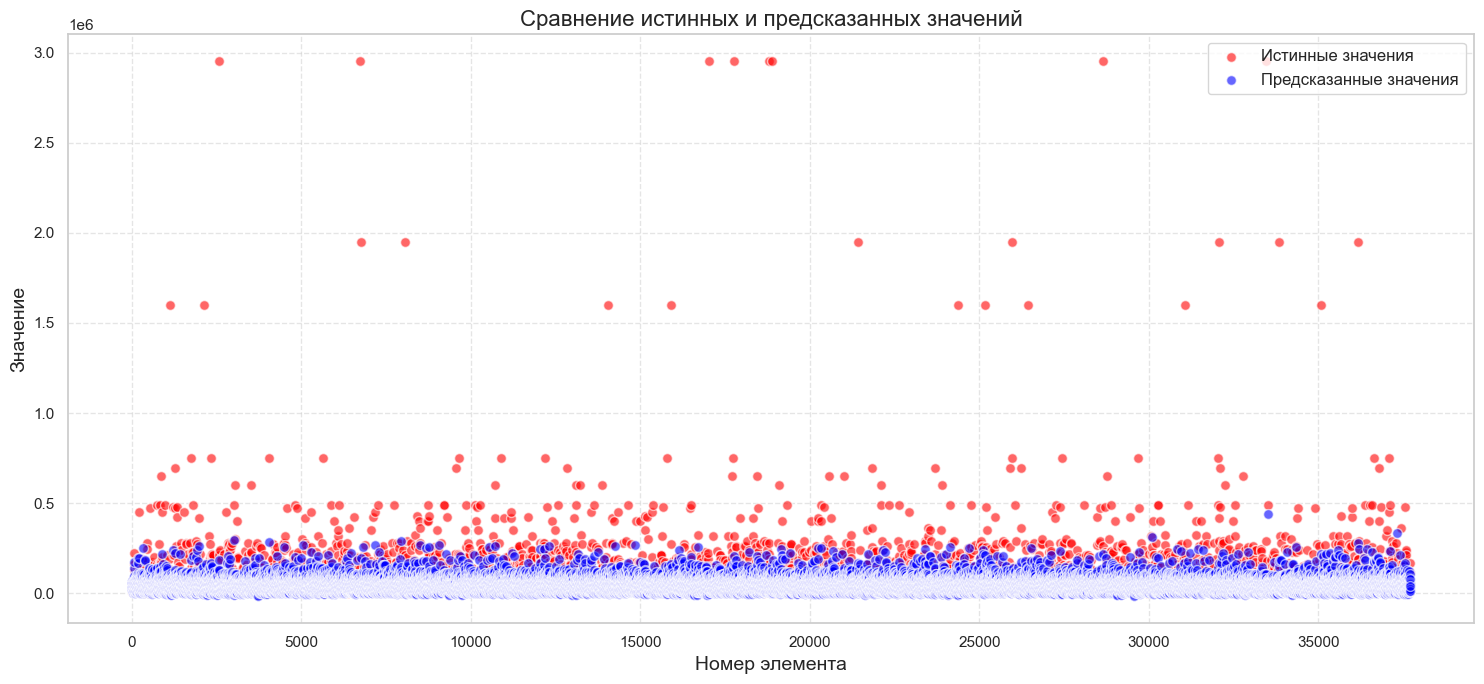

In [141]:
# Вызов функции для построения графика
plot_y_test_vs_y_pred(y_test, stacking_predictions, title='Сравнение истинных и предсказанных значений')

## 2.Метамодель - Случайный лес

In [142]:
# Инициализация мета-модели (можно использовать любую другую модель)
meta_model_rf = RandomForestRegressor()

### 2.1 Оригинальные признаки передаются модели

In [143]:
# Список базовых моделей для стекинга
estimators = [
    ('cb',cb_model),
    ('lgbm', lgb_model),
    ('lr', lr_model),
    # ('xgb', xgb_model),
    ('rf', rf_model)
]

# Создание стекинг-регрессора
stacking_regressor = StackingRegressor(
    estimators=estimators,
    final_estimator=meta_model_rf,
    cv=5,            # Количество фолдов для кросс-валидации
    n_jobs=-1,       # Использовать все доступные ядра процессора
    passthrough=True # Если True, оригинальные признаки будут переданы мета-модели
)

# Обучение стекинг-регрессора
stacking_regressor.fit(X_train_encoded, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1254
[LightGBM] [Info] Number of data points in the train set: 150826, number of used features: 11
[LightGBM] [Info] Start training from score 43890.785316
0:	learn: 79526.7362468	total: 18.2ms	remaining: 18.1s
1:	learn: 79219.5197007	total: 32.6ms	remaining: 16.3s
2:	learn: 78939.6440897	total: 46ms	remaining: 15.3s
3:	learn: 78669.6493966	total: 58.9ms	remaining: 14.7s
4:	learn: 78413.1747267	total: 74.1ms	remaining: 14.8s
5:	learn: 78166.1078572	total: 91.8ms	remaining: 15.2s
6:	learn: 77928.2463377	total: 107ms	remaining: 15.2s
7:	learn: 77709.2111144	total: 122ms	remaining: 15.1s
8:	learn: 77501.5272535	total: 141ms	remaining: 15.5s
9:	learn: 77300.0742275	total: 162ms	remaining: 16.1s
10:	learn: 77108.5675268	total: 179ms	remaini

StackingRegressor(cv=5,
                  estimators=[('cb',
                               <catboost.core.CatBoostRegressor object at 0x1745fb750>),
                              ('lgbm',
                               LGBMRegressor(learning_rate=0.05, max_depth=6,
                                             n_estimators=1000,
                                             random_state=42)),
                              ('lr', LinearRegression()),
                              ('rf',
                               RandomForestRegressor(n_jobs=-1,
                                                     random_state=42))],
                  final_estimator=RandomForestRegressor(), n_jobs=-1,
                  passthrough=True)

In [144]:
# Предсказания стекинг-модели
stacking_predictions = stacking_regressor.predict(X_test_encoded)

# Вычисление RMSE для стекинг-модели
stacking_rmse = np.sqrt(mean_squared_error(y_test, stacking_predictions))
print(f'RMSE для стекинг-модели: {stacking_rmse:.4f}')

RMSE для стекинг-модели: 71755.0654


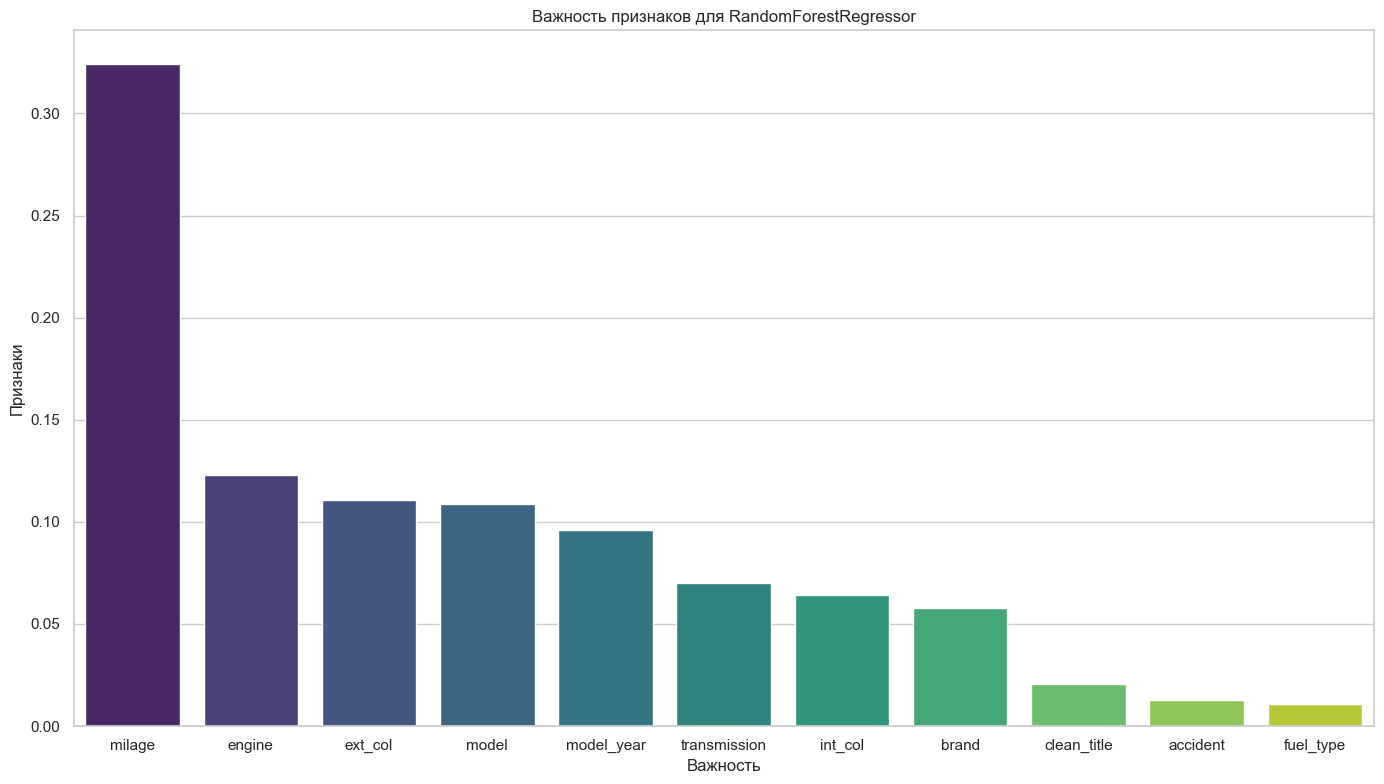

In [145]:
# Получение важности признаков для RandomForestRegressor
rf_importances = stacking_regressor.named_estimators_['rf'].feature_importances_
rf_feature_names = X_train_encoded.columns.tolist()

rf_importance_df = pd.DataFrame({
    'Признак': rf_feature_names,
    'Важность': rf_importances
}).sort_values(by='Важность', ascending=False)

# Визуализация
plt.figure(figsize=(14, 8))
sns.barplot(x='Признак', y='Важность', data=rf_importance_df, palette='viridis')
plt.title("Важность признаков для RandomForestRegressor")
plt.xlabel("Важность")
plt.ylabel("Признаки")
plt.tight_layout()
plt.show()

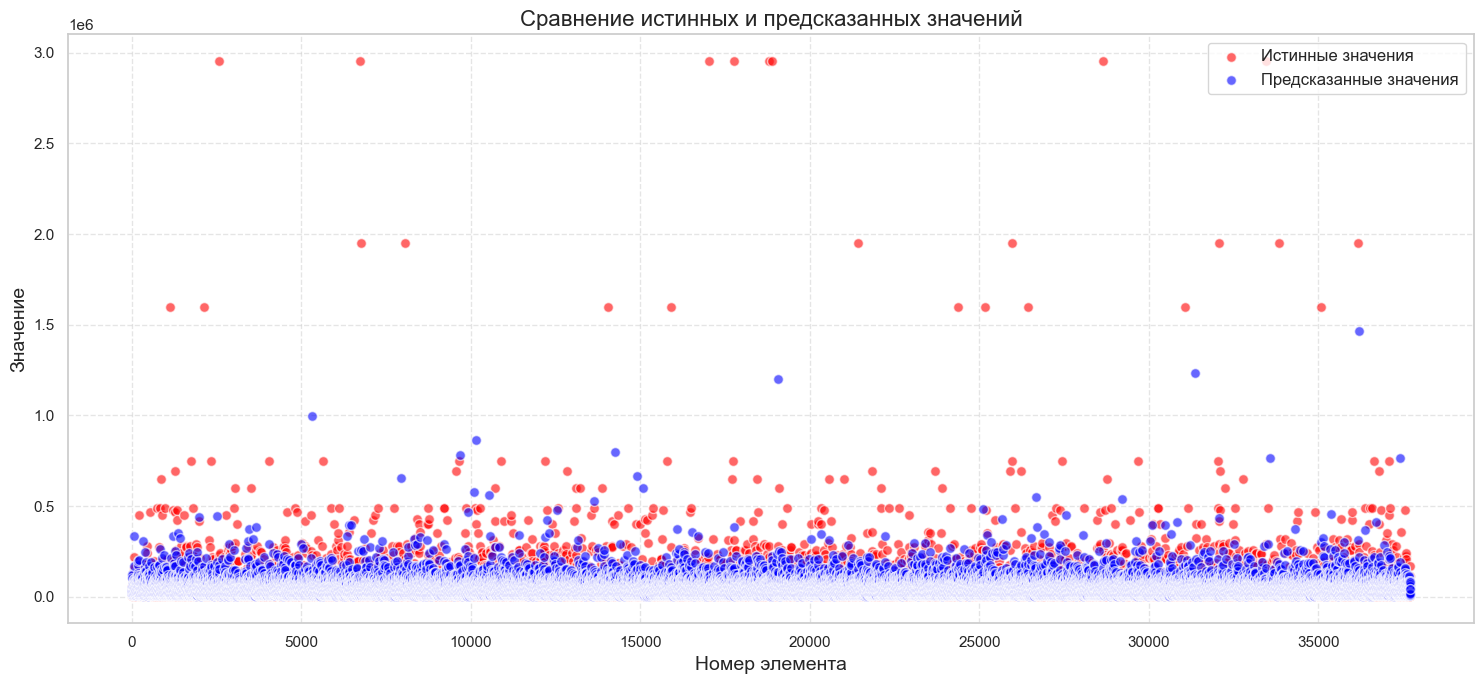

In [146]:
# Вызов функции для построения графика
plot_y_test_vs_y_pred(y_test, stacking_predictions, title='Сравнение истинных и предсказанных значений')

### 2.2 Оригинальные признаки не передаются модели

In [147]:
# Список базовых моделей для стекинга
estimators = [
    ('cb',cb_model),
    ('lgbm', lgb_model),
    ('lr', lr_model),
    # ('xgb', xgb_model),
    ('rf', rf_model)
]

# Создание стекинг-регрессора
stacking_regressor = StackingRegressor(
    estimators=estimators,
    final_estimator=meta_model_rf,
    cv=5,            # Количество фолдов для кросс-валидации
    n_jobs=-1,       # Использовать все доступные ядра процессора
    passthrough=False # Если True, оригинальные признаки будут переданы мета-модели
)

# Обучение стекинг-регрессора
stacking_regressor.fit(X_train_encoded, y_train)

0:	learn: 79526.7362468	total: 96.8ms	remaining: 1m 36s
1:	learn: 79219.5197007	total: 106ms	remaining: 53s
2:	learn: 78939.6440897	total: 137ms	remaining: 45.5s
3:	learn: 78669.6493966	total: 148ms	remaining: 36.9s
4:	learn: 78413.1747267	total: 168ms	remaining: 33.3s
5:	learn: 78166.1078572	total: 182ms	remaining: 30.2s
6:	learn: 77928.2463377	total: 216ms	remaining: 30.7s
7:	learn: 77709.2111144	total: 229ms	remaining: 28.4s
8:	learn: 77501.5272535	total: 260ms	remaining: 28.6s
9:	learn: 77300.0742275	total: 283ms	remaining: 28s
10:	learn: 77108.5675268	total: 396ms	remaining: 35.6s
11:	learn: 76928.0835784	total: 433ms	remaining: 35.7s
12:	learn: 76754.7171004	total: 454ms	remaining: 34.5s
13:	learn: 76592.2663153	total: 479ms	remaining: 33.7s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.239063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1254
[LightGBM] [Info] Number of data points in the

StackingRegressor(cv=5,
                  estimators=[('cb',
                               <catboost.core.CatBoostRegressor object at 0x1745fb750>),
                              ('lgbm',
                               LGBMRegressor(learning_rate=0.05, max_depth=6,
                                             n_estimators=1000,
                                             random_state=42)),
                              ('lr', LinearRegression()),
                              ('rf',
                               RandomForestRegressor(n_jobs=-1,
                                                     random_state=42))],
                  final_estimator=RandomForestRegressor(), n_jobs=-1)

In [148]:
# Предсказания стекинг-модели
stacking_predictions = stacking_regressor.predict(X_test_encoded)

# Вычисление RMSE для стекинг-модели
stacking_rmse = np.sqrt(mean_squared_error(y_test, stacking_predictions))
print(f'RMSE для стекинг-модели: {stacking_rmse:.4f}')

RMSE для стекинг-модели: 71940.2946


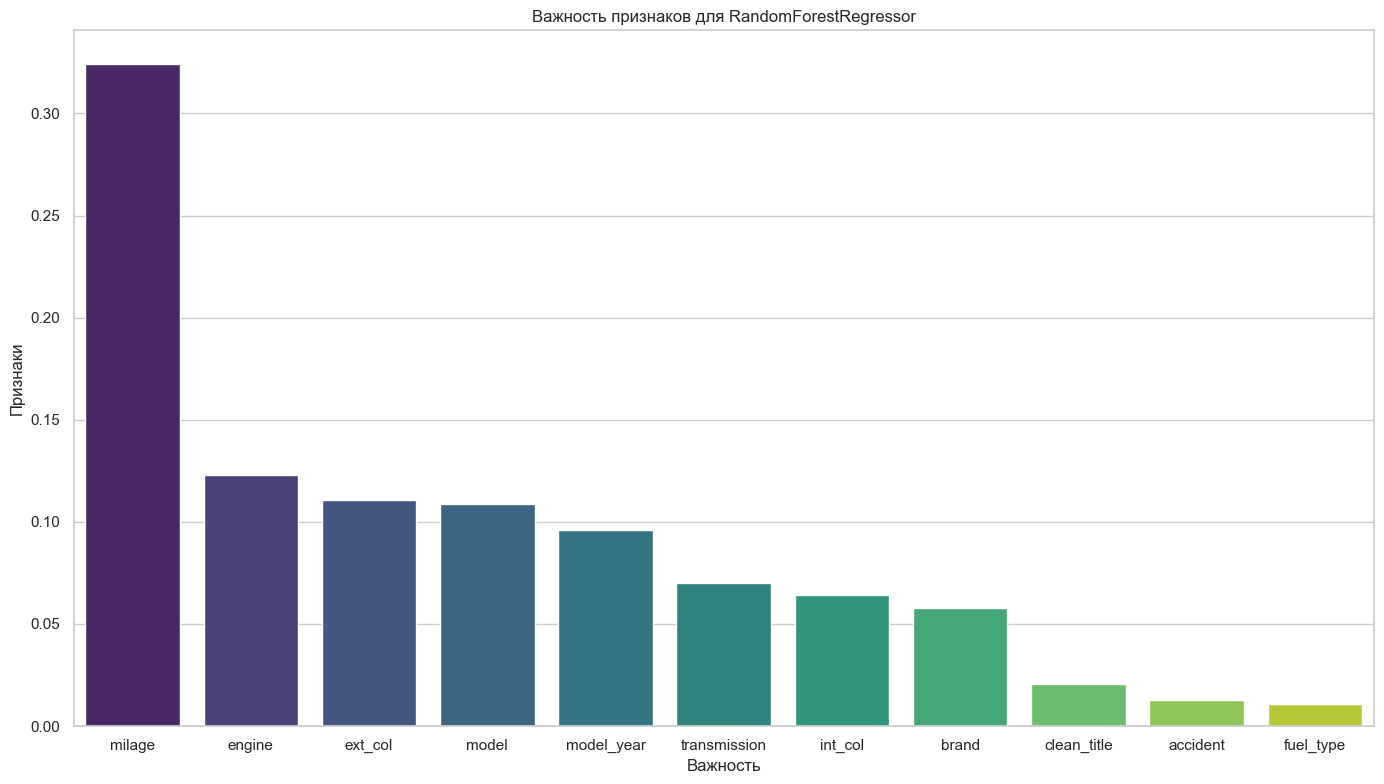

In [149]:
# Получение важности признаков для RandomForestRegressor
rf_importances = stacking_regressor.named_estimators_['rf'].feature_importances_
rf_feature_names = X_train_encoded.columns.tolist()

rf_importance_df = pd.DataFrame({
    'Признак': rf_feature_names,
    'Важность': rf_importances
}).sort_values(by='Важность', ascending=False)

# Визуализация
plt.figure(figsize=(14, 8))
sns.barplot(x='Признак', y='Важность', data=rf_importance_df, palette='viridis')
plt.title("Важность признаков для RandomForestRegressor")
plt.xlabel("Важность")
plt.ylabel("Признаки")
plt.tight_layout()
plt.show()

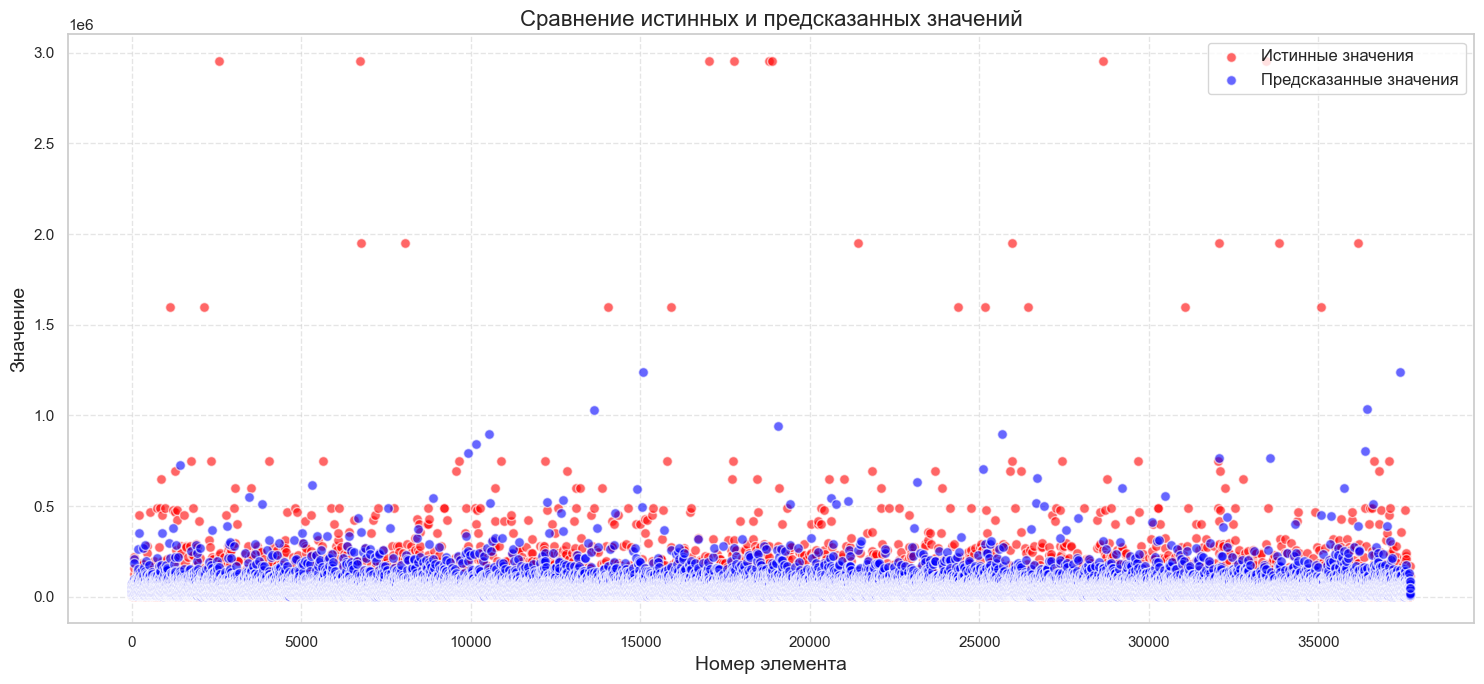

In [150]:
# Вызов функции для построения графика
plot_y_test_vs_y_pred(y_test, stacking_predictions, title='Сравнение истинных и предсказанных значений')

## 3. Метамодель - градиентный бустинг

In [151]:
# Мета-модель:
meta_model_cb = CatBoostRegressor(
    iterations=500,
    learning_rate=0.03,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=42,
    verbose=False  # Установите в False для отключения вывода
)

### 3.1 Оригинальные признаки передаются модели

In [152]:
# Список базовых моделей для стекинга
estimators = [
    ('cb', cb_model),
    ('lgbm', lgb_model),
    ('lr', lr_model),
    ('rf', rf_model)
]

# Создание стекинг-регрессора с мета-моделью CatBoostRegressor
stacking_regressor = StackingRegressor(
    estimators=estimators,
    final_estimator=meta_model_cb,
    cv=5,            # Количество фолдов для кросс-валидации
    n_jobs=-1,       # Использовать все доступные ядра процессора
    passthrough=True # Если True, оригинальные признаки будут переданы мета-модели
)

# Обучение стекинг-регрессора
stacking_regressor.fit(X_train_encoded, y_train)

0:	learn: 79526.7362468	total: 30.4ms	remaining: 30.4s
1:	learn: 79219.5197007	total: 58.2ms	remaining: 29s
2:	learn: 78939.6440897	total: 75.2ms	remaining: 25s
3:	learn: 78669.6493966	total: 101ms	remaining: 25.1s
4:	learn: 78413.1747267	total: 169ms	remaining: 33.7s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1254
[LightGBM] [Info] Number of data points in the train set: 150826, number of used features: 11
[LightGBM] [Info] Start training from score 43890.785316
5:	learn: 78166.1078572	total: 212ms	remaining: 35.1s
6:	learn: 77928.2463377	total: 222ms	remaining: 31.5s
7:	learn: 77709.2111144	total: 251ms	remaining: 31.1s
8:	learn: 77501.5272535	total: 284ms	remaining: 31.3s
9:	learn: 77300.0742275	total: 309ms	remaining: 30.6s
10:	learn: 77108.5675268	total: 321ms	remaining: 2

StackingRegressor(cv=5,
                  estimators=[('cb',
                               <catboost.core.CatBoostRegressor object at 0x1745fb750>),
                              ('lgbm',
                               LGBMRegressor(learning_rate=0.05, max_depth=6,
                                             n_estimators=1000,
                                             random_state=42)),
                              ('lr', LinearRegression()),
                              ('rf',
                               RandomForestRegressor(n_jobs=-1,
                                                     random_state=42))],
                  final_estimator=<catboost.core.CatBoostRegressor object at 0x30be1d510>,
                  n_jobs=-1, passthrough=True)

In [153]:
# Предсказания стекинг-модели
stacking_predictions = stacking_regressor.predict(X_test_encoded)

# Вычисление RMSE для стекинг-модели
stacking_rmse = np.sqrt(mean_squared_error(y_test, stacking_predictions))
print(f'RMSE для стекинг-модели: {stacking_rmse:.4f}')

RMSE для стекинг-модели: 68309.9939


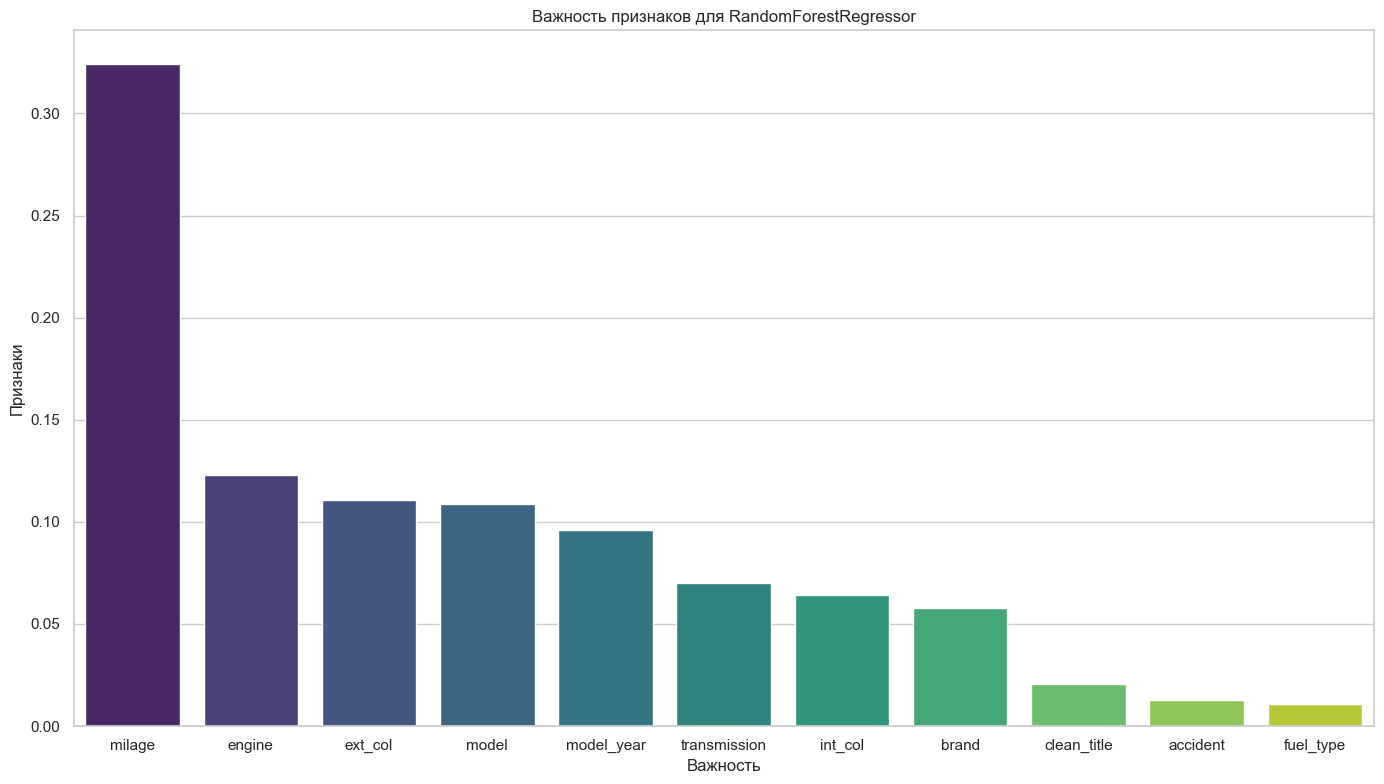

In [154]:
# Получение важности признаков для RandomForestRegressor
rf_importances = stacking_regressor.named_estimators_['rf'].feature_importances_
rf_feature_names = X_train_encoded.columns.tolist()

rf_importance_df = pd.DataFrame({
    'Признак': rf_feature_names,
    'Важность': rf_importances
}).sort_values(by='Важность', ascending=False)

# Визуализация
plt.figure(figsize=(14, 8))
sns.barplot(x='Признак', y='Важность', data=rf_importance_df, palette='viridis')
plt.title("Важность признаков для RandomForestRegressor")
plt.xlabel("Важность")
plt.ylabel("Признаки")
plt.tight_layout()
plt.show()

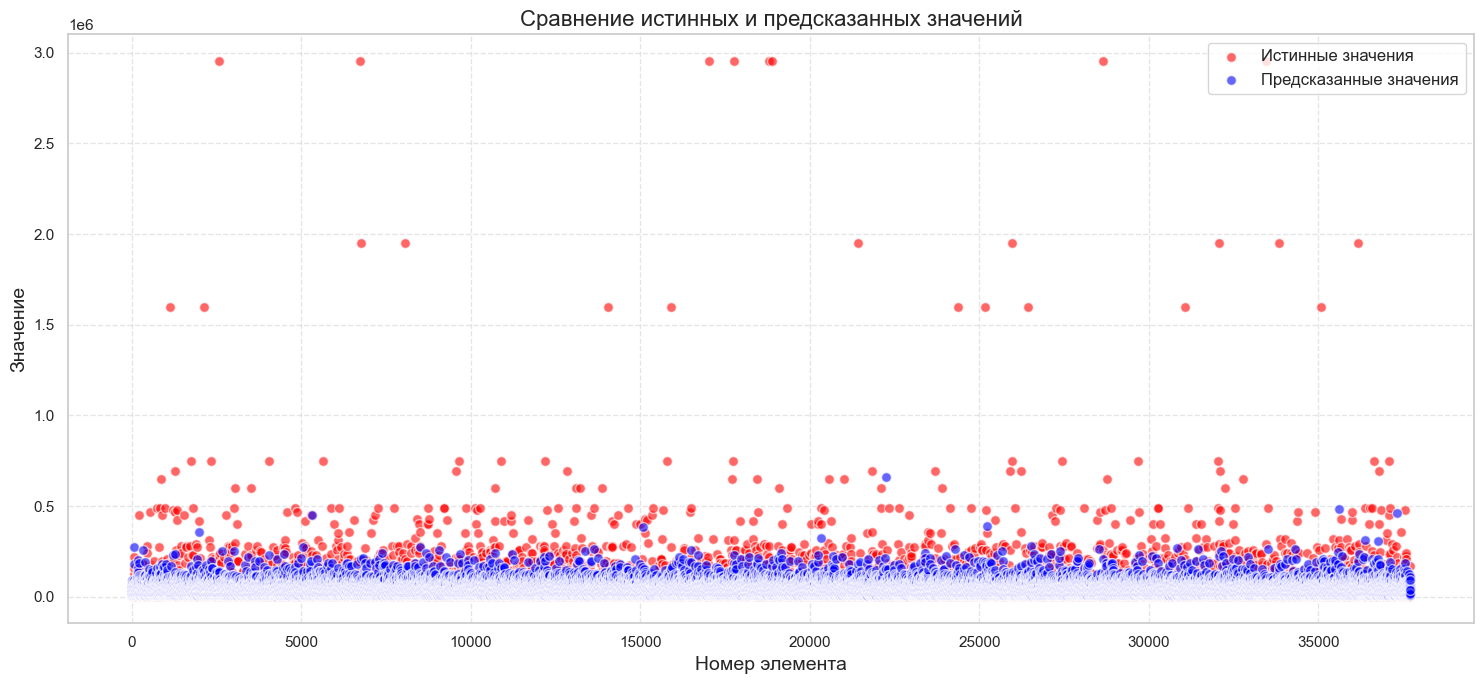

In [155]:
# Вызов функции для построения графика
plot_y_test_vs_y_pred(y_test, stacking_predictions, title='Сравнение истинных и предсказанных значений')

### 3.2 Оригинальные признаки не передаются модели

In [156]:
# Список базовых моделей для стекинга
estimators = [
    ('cb', cb_model),
    ('lgbm', lgb_model),
    ('lr', lr_model),
    ('rf', rf_model)
]

# Создание стекинг-регрессора с мета-моделью CatBoostRegressor
stacking_regressor = StackingRegressor(
    estimators=estimators,
    final_estimator=meta_model_cb,
    cv=5,            # Количество фолдов для кросс-валидации
    n_jobs=-1,       # Использовать все доступные ядра процессора
    passthrough=False # Если True, оригинальные признаки будут переданы мета-модели
)

# Обучение стекинг-регрессора
stacking_regressor.fit(X_train_encoded, y_train)

0:	learn: 79526.7362468	total: 11.9ms	remaining: 11.9s
1:	learn: 79219.5197007	total: 21.6ms	remaining: 10.8s
2:	learn: 78939.6440897	total: 28ms	remaining: 9.3s
3:	learn: 78669.6493966	total: 33ms	remaining: 8.21s
4:	learn: 78413.1747267	total: 37.6ms	remaining: 7.47s
5:	learn: 78166.1078572	total: 41.6ms	remaining: 6.88s
6:	learn: 77928.2463377	total: 46.4ms	remaining: 6.59s
7:	learn: 77709.2111144	total: 51.3ms	remaining: 6.36s
8:	learn: 77501.5272535	total: 55.7ms	remaining: 6.13s
9:	learn: 77300.0742275	total: 62.8ms	remaining: 6.22s
10:	learn: 77108.5675268	total: 69.7ms	remaining: 6.26s
11:	learn: 76928.0835784	total: 75.8ms	remaining: 6.24s
12:	learn: 76754.7171004	total: 83ms	remaining: 6.3s
13:	learn: 76592.2663153	total: 94.3ms	remaining: 6.64s
14:	learn: 76430.5795496	total: 103ms	remaining: 6.75s
15:	learn: 76280.7652736	total: 108ms	remaining: 6.66s
16:	learn: 76140.1748374	total: 113ms	remaining: 6.54s
17:	learn: 76005.1917802	total: 118ms	remaining: 6.44s
18:	learn: 758

StackingRegressor(cv=5,
                  estimators=[('cb',
                               <catboost.core.CatBoostRegressor object at 0x1745fb750>),
                              ('lgbm',
                               LGBMRegressor(learning_rate=0.05, max_depth=6,
                                             n_estimators=1000,
                                             random_state=42)),
                              ('lr', LinearRegression()),
                              ('rf',
                               RandomForestRegressor(n_jobs=-1,
                                                     random_state=42))],
                  final_estimator=<catboost.core.CatBoostRegressor object at 0x30be1d510>,
                  n_jobs=-1)

In [157]:
# Предсказания стекинг-модели
stacking_predictions = stacking_regressor.predict(X_test_encoded)

# Вычисление RMSE для стекинг-модели
stacking_rmse = np.sqrt(mean_squared_error(y_test, stacking_predictions))
print(f'RMSE для стекинг-модели: {stacking_rmse:.4f}')

RMSE для стекинг-модели: 68237.9528


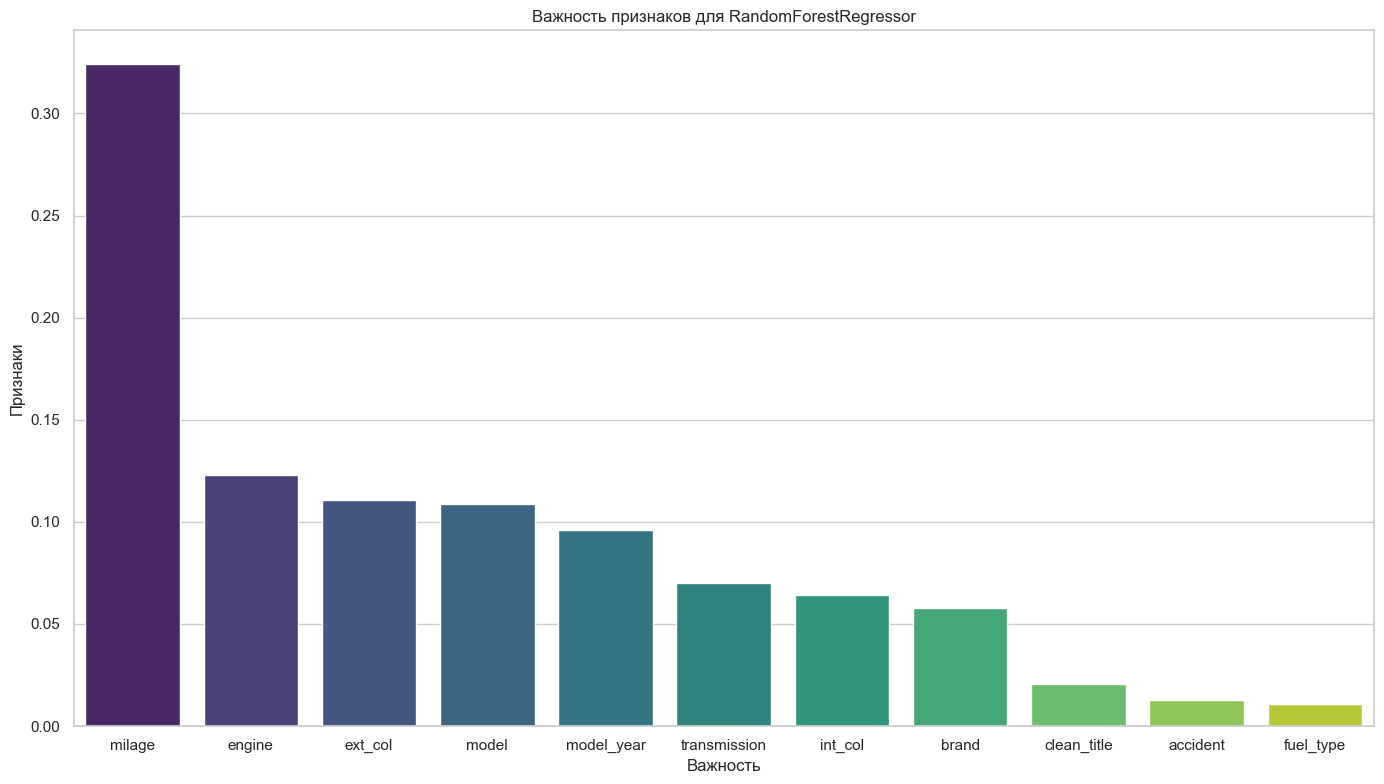

In [158]:
# Получение важности признаков для RandomForestRegressor
rf_importances = stacking_regressor.named_estimators_['rf'].feature_importances_
rf_feature_names = X_train_encoded.columns.tolist()

rf_importance_df = pd.DataFrame({
    'Признак': rf_feature_names,
    'Важность': rf_importances
}).sort_values(by='Важность', ascending=False)

# Визуализация
plt.figure(figsize=(14, 8))
sns.barplot(x='Признак', y='Важность', data=rf_importance_df, palette='viridis')
plt.title("Важность признаков для RandomForestRegressor")
plt.xlabel("Важность")
plt.ylabel("Признаки")
plt.tight_layout()
plt.show()

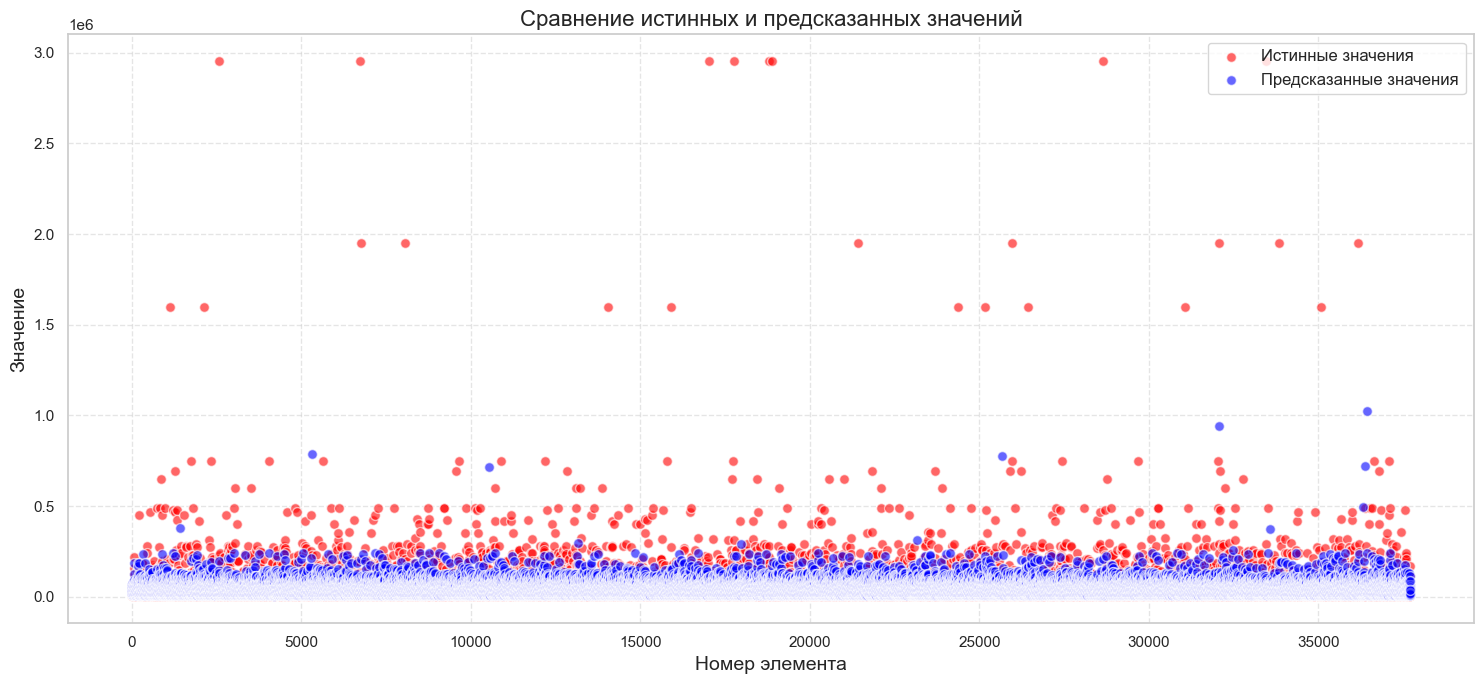

In [159]:
# Вызов функции для построения графика
plot_y_test_vs_y_pred(y_test, stacking_predictions, title='Сравнение истинных и предсказанных значений')